## Introduction:
The objective of this notebook is to provide a behind the scene view of what is involved in developing a predictive model that form the basis of a credit scoring procedure.
 
### Building a Credit Scoring Model  in a nutshell:
To build a credit scoring model, data including a large  collection of loans that are known to be "good" and "bad" loans along with attributes pertaining to the borrower of the loan (e.g. age, homeownership, number of previous loans, etc.),  is required. These attributes are then used to build a statistical model that gives an estimate of the probability that a loan would be "bad".  Next, this model is used to predict the probability of a new potential borrower's loan being a bad loan or in other words defaulting, which would depend on on his or her resemblance to the attributes of those who have already defaulted in the past indicated by the new potential borrowers credit score and use this information to asses the relevant interest rate that should be charged on the loan if it were to be approved. 

### Data:
The dataset that will be used here is a publicly available data set of  the loans issued by the peer to peer online  lending platform called the Lending Club. The data was downloaded from the Kaggle website (https://www.kaggle.com/wendykan/lending-club-loan-data). 



##  Preliminaries: Import Packages, Load Data and Familiarise
#### Import Packages 

In [116]:

import datetime as dt
import pandas as pd
import numpy as np
from scipy import stats, integrate
import matplotlib.pylab as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
sns.set(color_codes=True)
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics

#### Read and take a look at the data

In [117]:
loanbook=pd.read_csv('../rawdata/loan.csv', low_memory=False)


In [118]:
loanbook.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
id                             887379 non-null int64
member_id                      887379 non-null int64
loan_amnt                      887379 non-null float64
funded_amnt                    887379 non-null float64
funded_amnt_inv                887379 non-null float64
term                           887379 non-null object
int_rate                       887379 non-null float64
installment                    887379 non-null float64
grade                          887379 non-null object
sub_grade                      887379 non-null object
emp_title                      835922 non-null object
emp_length                     887379 non-null object
home_ownership                 887379 non-null object
annual_inc                     887375 non-null float64
verification_status            887379 non-null object
issue_d                        887379 non-null object
loan_status          

In [119]:
loanbook.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Output from loanbook.info() gives total no. of loans as 887379 and 74 columns


####  Distribution of Loan Amounts 

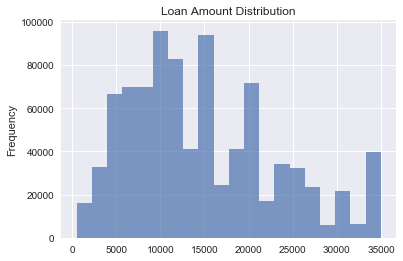

In [120]:
y= loanbook['loan_amnt']
pd.Series(y).plot(kind='hist',alpha=.7, bins=20, title='Loan Amount Distribution')

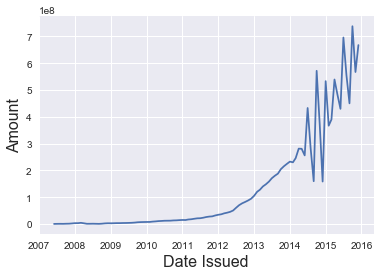

In [121]:
loanbook['issue_d'] =  pd.to_datetime(loanbook['issue_d'], format='%b-%Y')

Amount=loanbook.groupby(by=['issue_d'])['loan_amnt'].sum()

plt.plot(Amount)
plt.xlabel('Date Issued', fontsize=16)
plt.ylabel('Amount', fontsize=16)
plt.show()


## Creation of the binary variable "outcome"  for Default vs. Fully Paid.
The feature 'loan_status' gives the current status of the loan. Using this feature we could classify each loan into a bad loan  (outcome=1), a good loan (outcome=0) or a loan that is neither good nor bad (outcome =2). Into the last category falls the loans that are current whose outcome is still to be determined and loans that were never approved. 

In [122]:
# look at the distribution of the loans by status.
loan_status_freq =loanbook['loan_status'].value_counts().to_frame()
loan_status_freq

,loan_status
Current,601779
Fully Paid,207723
Charged Off,45248
Late (31-120 days),11591
Issued,8460
In Grace Period,6253
Late (16-30 days),2357
Does not meet the credit policy. Status:Fully Paid,1988
Default,1219
Does not meet the credit policy. Status:Charged Off,761


#### Group loan status into a default group and nodefault group as follows:
1. Default Group:  Charged off, Late(31-120 days), In Grace Period, Late(16-30 days), Default.
2. No Default Group : Fully Paid
3. Not included:
    1. Current, Does not meet the credit policy. Issued
    2. Does not meet the credit policy.Status:Charged off, Does not meet the credit policy: Fully Paid

In [123]:

loan_status_dict ={"Fully Paid" : 0 , 
                   "Charged Off": 1 , "Late (31-120 days)": 1,  "In Grace Period":1, "Late (16-30 days)":1,
                   "Default":1,
                   "Current" : 2 ,"Issued": 2,
                   "Does not meet the credit policy. Status:Fully Paid": 2,
                   "Does not meet the credit policy. Status:Charged Off": 2}

loanbook['outcome']= loanbook.loan_status.map(loan_status_dict)



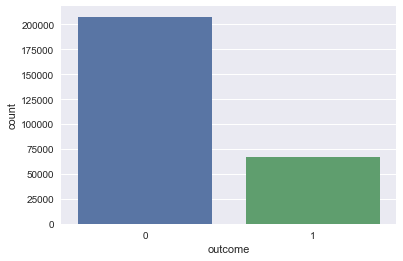

In [124]:
#Keep only the rows where outcome is 0 or 1, excluding the rows where outcome =2
loanbook = loanbook[(loanbook['outcome'] < 2) ]

# Take a look at the distribution of the dependent variable outcome: 
sns.countplot(data=loanbook,
                  x ='outcome')

In [125]:
percent_default = (loanbook['outcome'].value_counts()/len(loanbook['outcome'])) *100
percent_default

0    75.703285
1    24.296715
Name: outcome, dtype: float64

## Handling Imbalance in the Outcome:

From the plot above we can see that we have an imbalance in the pecentages of good and bad loans( 75% good loans and 25% bad loans).  Whilst this imbalance is not severe we need to take steps to account for this imbalance. 

1. Imbalace has implications on the appropriate evaluation metric we would use to evaluate the models. In the case of loan  default it is more detrimental to predict a bad loan as good as opposed to a good loan being bad. In the former case a definite loss would be incurred and in the latter a potential opportunity would be lost.
 Accuracy which tells us how many loans were correctly labeled and given by the ratio of correctly predicted observations ( positive and negative) to the total observations would be misleading as it is more influneced by the majority class which in this case is the good loans. Instead Precision and Recall, and AUC would be better model evaluation metrics.
 Recall is a measure of how often the model is able to detect the bad loans and Precision is a measure of how likley the model is correct when it predicts a loan to be bad. AUROC, the area under the Reciever operating curve is the expectation that a uniformly drawn random bad loan is ranked before a uniformly drawn random good loan.

2. For Model Evaluation purposes we will be splitting the data into two sets. One for building or training the model (70%) and the other for testing (30 %). In this split we need to ensure that both sets have the same ratio of good to bad loans. In the case of imbalance we would need to use stratified sampling to ensure this balance.

3. One approach to mitigating the effect of imbalance is by means of sampling. This could be by  oversampling of the minority group or undersampling the majority group or using a hybrid of these two approaches. In this analysis we will use a technique called SMOTE(Synthetic Minority Over-Sampling Technique) It is a combination of oversampling and undersampling, but the oversampling approach is not by means of simply replicating the minority class but by means of an algorthm constructing new minority class data. 
   


##  Features to retain for further exploration and those to be dropped.


####   Rationale for  dropping the first set of  features
1. As we are only interested in those features that would be available at the time of loan application we will drop
   those features that would be available only after the loan has been approved.
2. We will also drop those features that are unique to each loan applicant ( loan id, url, member_id).
3. The features 'desc', 'title', 'zip_code'  may be useful but they will need to be engineered
   further to be included in this model and taking into consideration the scope of this project they will not be included.
4. Grade will be retained for further exploration of the data but will not be included as a predictor variable as the objective    of this project is to illustrate the building of a model that could be used to grade the loans.

In [126]:
col_to_drop =['id','member_id','funded_amnt','funded_amnt_inv', 'pymnt_plan', 'url','desc','title','initial_list_status',
               'out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int',
               'total_rec_late_fee','recoveries', 'collection_recovery_fee','last_pymnt_d','last_pymnt_amnt','next_pymnt_d',
               'last_credit_pull_d','policy_code', 'zip_code' ,  'sub_grade', 'installment']

loanbook.drop(col_to_drop, axis=1, inplace=True)


In [127]:
loanbook.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274391 entries, 0 to 887371
Data columns (total 49 columns):
loan_amnt                      274391 non-null float64
term                           274391 non-null object
int_rate                       274391 non-null float64
grade                          274391 non-null object
emp_title                      259161 non-null object
emp_length                     274391 non-null object
home_ownership                 274391 non-null object
annual_inc                     274391 non-null float64
verification_status            274391 non-null object
issue_d                        274391 non-null datetime64[ns]
loan_status                    274391 non-null object
purpose                        274391 non-null object
addr_state                     274391 non-null object
dti                            274391 non-null float64
delinq_2yrs                    274391 non-null float64
earliest_cr_line               274391 non-null object
inq_last_6mt

Now out of the 74 features that we started out with we have pared it down to 48 features and one outcome variable. We will take a look at these features and prepare them for model fitting. If there are two many levels in a categorical feature it will affect the performance of the model. Looking at the number of unique values for each feature will enable us to decide how to bin them so we have a fewer number of categories for the categorical features. Binning in the case of numeric variables will help with ameliorating the effect of long extreme values whose presence will be evident to us by looking at the histograms of the distibutions of these features. 


#### Categorical Features:


In [128]:
# look at the number of unique categories for each categorical feature
for col_name in loanbook.columns:
    if loanbook[col_name].dtypes == 'object':
        unique_cat = len(loanbook[col_name].unique())
        print(" '{col_name}' : {unique_cat} unique categories".format(col_name=col_name, unique_cat=unique_cat))
        

 'term' : 2 unique categories
 'grade' : 7 unique categories
 'emp_title' : 139903 unique categories
 'emp_length' : 12 unique categories
 'home_ownership' : 6 unique categories
 'verification_status' : 3 unique categories
 'loan_status' : 6 unique categories
 'purpose' : 14 unique categories
 'addr_state' : 51 unique categories
 'earliest_cr_line' : 649 unique categories
 'application_type' : 2 unique categories
 'verification_status_joint' : 4 unique categories


Looking at the number of unique categories for each feature emp_title, addr_state and earliest_cr _line have a high number of categories. Emp_title refers to the job title which appears to be very specific to the applicant. Regrouping this into smaller categories would require a lot more extensive exploration and for the sake of time we will drop this feature. 
Earliest_cr_line refers to the month the borrowers earliest credit line was opened. From this feature we will calculate the length of credit history for the borrower and use this in the model. The feature addr_state refers to the state in which the loan was issued. By looking a the loan defaults for each state we may be able to group the states as highly defaulting states and low default states. The other categories will be rebinned now into a fewer number of sub-categories for each.
Using the date of issue of the loan we will create a feature called year corresponding to the year the loan was issued.

In [129]:
# drop emp_title 
loanbook.drop('emp_title', axis=1,  inplace= True)

In [130]:
#regroup purpose
loanbook['purpose'].unique()

array(['credit_card', 'car', 'small_business', 'other', 'wedding',
       'debt_consolidation', 'home_improvement', 'major_purchase',
       'medical', 'moving', 'vacation', 'house', 'renewable_energy',
       'educational'], dtype=object)

#Consolidate purpose into three categories
debt = 'credit card','debt_consolidation', 
consumer= 'car', wedding, medical, vacation, major_purchase , home improvement, house, renewable_energy, moving, other, educational,
small business = business

In [131]:
purpose_dict={ 'credit_card':'debt','debt_consolidation': 'debt', 
                'car': 'consumer', 'wedding':'consumer', 'medical': 'consumer', 'vacation':'consumer','major_purchase':'consumer',
               'home_improvement': 'home', 'house': 'home', 'renewable_energy':'home', 'moving': 'consumer',
               'educational': 'consumer', 'small_business': 'business', 'other': 'consumer'}

loanbook['purpose_regrp'] = loanbook.purpose.map(purpose_dict)

loanbook.purpose_regrp.value_counts()

debt        216016
consumer     35093
home         18198
business      5084
Name: purpose_regrp, dtype: int64

In [132]:
#regroup home_ownership
loanbook['home_ownership'].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER', 'NONE', 'ANY'], dtype=object)

In [133]:
#consolidate home ownership into four groups: Mortgage, RENT, OWN and OTHER
home_dict={'RENT':'RENT', 'OWN': 'OWN', 'MORTGAGE': 'MORTGAGE', 'OTHER': 'OTHER', 'NONE':'OTHER', "ANY":"OTHER"}

loanbook['home_regrp']=loanbook.home_ownership.map(home_dict)
loanbook.home_regrp.value_counts()

MORTGAGE    134317
RENT        115685
OWN          24204
OTHER          185
Name: home_regrp, dtype: int64

In [134]:
loanbook['emp_length'].unique()

array(['10+ years', '< 1 year', '3 years', '9 years', '4 years', '5 years',
       '1 year', '6 years', '2 years', '7 years', '8 years', 'n/a'], dtype=object)

In [135]:
#11067 loans present with no employment length. included these in a group n/a.
emp_dict={'< 1 year': "0-2",'10+ years': '10 +', '1 year': '0-2', '3 years': '3-10', '8 years': '3-10', '9 years': '3-10',
       '4 years': '3-10', '5 years': '3-10', '6 years': '3-10', '2 years': '0-2', '7 years': '3-10', 'n/a': 'n/a'}
          
loanbook['emp_length_regrp']=loanbook.emp_length.map(emp_dict)
loanbook.emp_length_regrp.value_counts()

3-10    113364
10 +     83448
0-2      66512
n/a      11067
Name: emp_length_regrp, dtype: int64

In [136]:
loanbook['application_type'].unique()

loanbook['application_type'].value_counts()

INDIVIDUAL    274385
JOINT              6
Name: application_type, dtype: int64

In [137]:
#term : The number of payments on the loan. Values are in months and can be either 36 or 60.
loanbook['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [138]:
#verified_status_joint:Indicates if the co-borrowers' joint income was verified by LC,
#                                    not verified, or if the income source was verified
loanbook['verification_status_joint'].unique()

ver_dict ={'Source Verified': 'Verified', 'Verified': 'Verified', 'Not Verified': 'Not Verified'}
loanbook['verified_joint_edt'] =loanbook.verification_status_joint.map(ver_dict)
loanbook['verified_joint_edt'].value_counts()

Verified        4
Not Verified    2
Name: verified_joint_edt, dtype: int64

In [139]:
#verification_status : Indicates if income was verified by LC, not verified, or if the income source was verified

loanbook['verification_status'].unique()

loanbook['verification_status'].value_counts()

#Combine 'Verified' and 'Source Verified'as Verified
ver_dict ={'Source Verified': 'Verified', 'Verified': 'Verified', 'Not Verified': 'Not Verified'}
loanbook['verified_edt'] =loanbook.verification_status.map(ver_dict)
loanbook['verified_edt'].value_counts()

Verified        183652
Not Verified     90739
Name: verified_edt, dtype: int64

In [140]:
#create column 'date_issued' with date of issue as year-month-date.
loanbook['date_issued'] =  pd.to_datetime(loanbook['issue_d'], format='%b-%Y')

#create column 'length_credithist' with no. of days of credit history.

loanbook['earliest_credit_date'] =  pd.to_datetime(loanbook['earliest_cr_line'], format='%b-%Y')
loanbook['td_credithist'] = loanbook['date_issued']-loanbook['earliest_credit_date']
loanbook['length_credithist'] = loanbook['td_credithist'].dt.total_seconds() / (24 * 60 * 60)
loanbook= loanbook.drop('td_credithist', axis=1)

In [141]:
#create year variable
loanbook.loc[:, 'year'] = loanbook.loc[:,'date_issued'].dt.year
loanbook.loc[:,'year'] =loanbook.loc[:,'year'].astype('category')

#### Numeric Features. 
We will first look a the frequency of occurernce of each value of the feature by looking at histogram plots. Plots that have long tails with skewed distributions indicate presence of outliers. These outliers could be legitimate or erroneous.  By binning these features the influence of these outliers could be reduced.

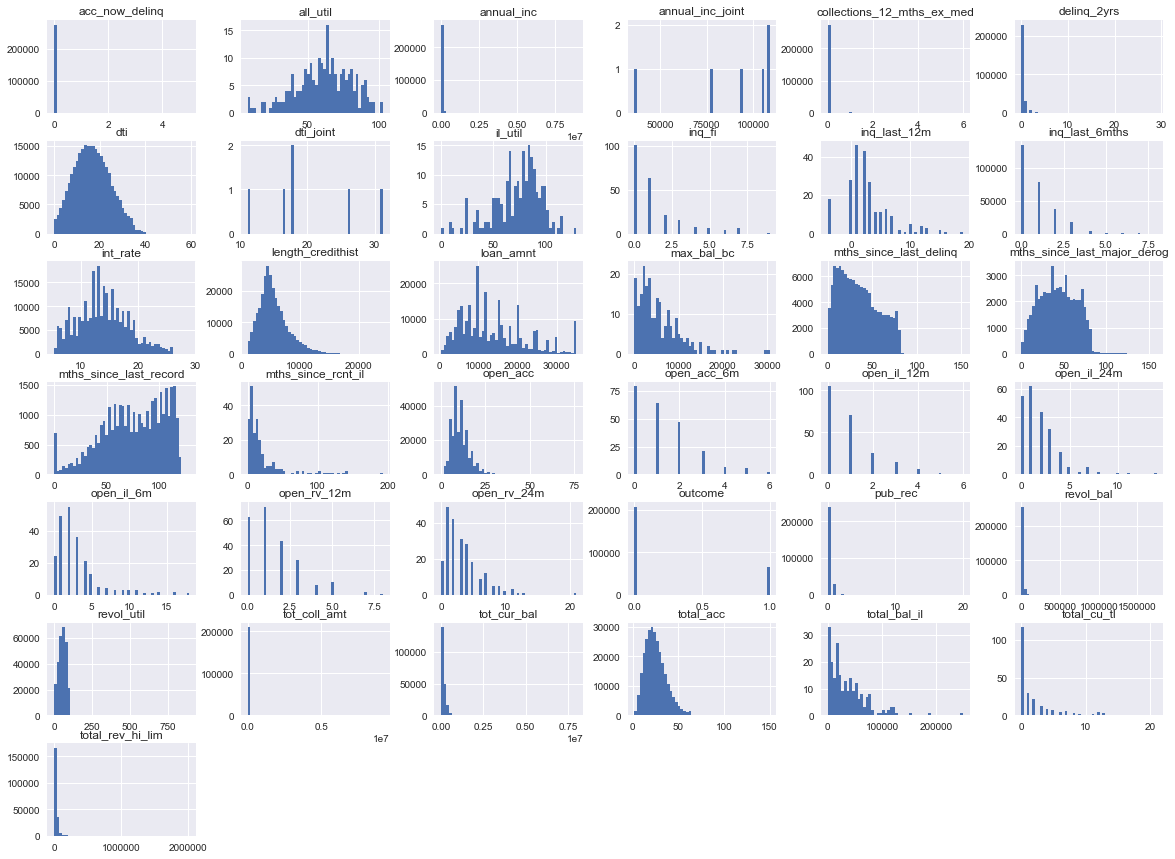

In [142]:


loanbook.hist(bins=50, figsize=(20, 15))
plt.show()

In [143]:
loanbook.describe()

,loan_amnt,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,...,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,outcome,length_credithist
count,274391.000000,274391.000000,2.743910e+05,274391.000000,274391.000000,274391.000000,123660.000000,35227.000000,274391.000000,274391.000000,...,226.000000,226.000000,226.000000,226.000000,2.104510e+05,226.000000,226.000000,226.000000,274391.000000,274391.000000
mean,13728.555237,13.922626,7.249446e+04,16.786753,0.263627,0.850724,34.871098,75.235416,11.002241,0.149203,...,1.526549,3.318584,5614.641593,60.933628,2.943548e+04,1.274336,2.168142,2.738938,0.242967,5581.872113
std,8188.024448,4.432766,6.060255e+04,7.886752,0.769022,1.066661,21.829885,29.507438,4.934560,0.450986,...,1.503094,2.874456,5053.513241,19.668965,2.945983e+04,1.780126,3.724758,3.883639,0.428876,2571.207469
min,500.000000,5.320000,3.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,7.900000,0.000000e+00,0.000000,0.000000,-4.000000,0.000000,1095.000000
25%,7500.000000,10.990000,4.500000e+04,10.920000,0.000000,0.000000,16.000000,54.000000,8.000000,0.000000,...,0.000000,1.000000,2108.250000,48.625000,1.320000e+04,0.000000,0.000000,1.000000,0.000000,3865.000000
50%,12000.000000,13.670000,6.200000e+04,16.440000,0.000000,1.000000,32.000000,77.000000,10.000000,0.000000,...,1.000000,3.000000,4280.000000,62.900000,2.201000e+04,1.000000,0.000000,2.000000,0.000000,5113.000000
75%,18875.000000,16.990000,8.700000e+04,22.290000,0.000000,1.000000,51.000000,101.000000,14.000000,0.000000,...,2.000000,4.750000,7895.750000,75.575000,3.650000e+04,2.000000,3.000000,4.000000,0.000000,6848.000000
max,35000.000000,28.990000,8.900060e+06,59.260000,29.000000,8.000000,152.000000,129.000000,76.000000,20.000000,...,8.000000,21.000000,30567.000000,102.800000,2.013133e+06,9.000000,21.000000,19.000000,1.000000,24138.000000


From the histograms above we can see that some of teh features do have long tails. Some features are continous and some are discrete. The continous features can be binned using automatically generated bins using qcut into 5 bins and the features that are discrete will be binned using custom bins using cut.

In [144]:
# Which features are continous and which ones are discreet?
float_features =[]
        
float_features=[(x, len(loanbook[x].unique())) for x in loanbook.columns if loanbook[x].dtypes == 'float64'] 

for x,y in sorted(float_features, key=lambda p:p[1]):
    print(" {x}: {y}" .format (x=x, y=y))


 acc_now_delinq: 6
 annual_inc_joint: 7
 dti_joint: 7
 collections_12_mths_ex_med: 8
 open_acc_6m: 8
 open_il_12m: 8
 inq_last_6mths: 9
 open_rv_12m: 9
 inq_fi: 10
 open_il_24m: 13
 pub_rec: 15
 open_rv_24m: 16
 open_il_6m: 18
 total_cu_tl: 19
 inq_last_12m: 19
 delinq_2yrs: 24
 open_acc: 59
 mths_since_rcnt_il: 63
 total_acc: 109
 mths_since_last_record: 124
 mths_since_last_delinq: 128
 mths_since_last_major_derog: 153
 il_util: 174
 all_util: 198
 total_bal_il: 204
 max_bal_bc: 218
 int_rate: 513
 revol_util: 1221
 loan_amnt: 1340
 length_credithist: 2355
 dti: 3996
 tot_coll_amt: 4384
 total_rev_hi_lim: 10001
 annual_inc: 20740
 revol_bal: 48515
 tot_cur_bal: 144945


#####  Bin using quantiles
Those features that have a high number of values could be biined into quantiles using qcut.

In [145]:
# Bin using quantiles 
numeric_cols= ['length_credithist','annual_inc','dti', 'revol_bal','revol_util', 'total_acc','open_acc', 
               'loan_amnt','mths_since_last_major_derog', 'open_il_6m', 'mths_since_rcnt_il',
               'total_bal_il','il_util', 'max_bal_bc',  'all_util',  'total_rev_hi_lim' ]
for i in numeric_cols:
    loanbook[i + "_quant"] =pd.qcut(loanbook[i], 5, labels=False)


##### Custom Bins 
Those features that have a fewer number of unique values will bin them into 6 bins .'None', '1-2', '3-4', '5-6', '6-7', '7+' 
Also we will custom bin those features eg. total collection amounts which should have a None(zero) bin

In [146]:
#custom bins
small_numeric = ['inq_last_6mths', 'open_acc_6m', 'open_il_12m', 'open_il_24m','open_rv_12m',
                 'open_rv_24m', 'inq_fi', 'total_cu_tl','inq_last_12m', 'acc_now_delinq' ]
bins = [-1, 0.9, 2.1, 4.1, 6.1, 7.1, 100]

group_names = ['None', '1-2', '3-4', '5-6', '6-7', '7+']

for i in small_numeric:
    loanbook[i + "_edit"] =pd.cut(loanbook[i], bins, labels=group_names)


In [147]:
loanbook['delinq_2yrs'].unique()

bins = [-1, 0.9, 5.1, 10.1, 15.1, 20.1, 40]

group_names = ['None', '1-5', '6-10 ', '11 - 15', '16-20', '20+']

loanbook['delinq_2yrs_edit'] = pd.cut(loanbook['delinq_2yrs'], bins, labels=group_names)
loanbook[['delinq_2yrs','delinq_2yrs_edit']].head()



,delinq_2yrs,delinq_2yrs_edit
0,0.0,None
1,0.0,None
2,0.0,None
3,0.0,None
5,0.0,None


In [148]:
#tot_coll_amt: Total collection amounts ever owed

bins = [-1, 0.90, 1000, 10000, 500000]

group_names = ['None', '1000', '10000', '50000 +']
loanbook['tot_coll_amt_quant'] = pd.cut(loanbook['tot_coll_amt'], bins, labels=group_names  )



loanbook['tot_coll_amt_quant'].value_counts


bins = [-1, 0.90, 1000, 10000, 500000]

group_names = ['None', '1000', '10000', '50000 +']
loanbook['tot_cur_bal_quant'] = pd.cut(loanbook['tot_cur_bal'], bins, labels=group_names  )

loanbook['tot_cur_bal_quant'].value_counts()

50000 +    191834
10000       12642
1000          428
None           53
Name: tot_cur_bal_quant, dtype: int64

In [149]:
loanbook['collections_12_mths_ex_med'].unique()
bins = [-1, 0.9, 1.1, 100]

group_names = ['None', '1', '2+']

loanbook['collections_12_mths_ex_med_quant'] = pd.cut(loanbook['collections_12_mths_ex_med'], bins, labels=group_names)

loanbook['collections_12_mths_ex_med_quant'].value_counts()

None    272401
1         1805
2+         129
Name: collections_12_mths_ex_med_quant, dtype: int64

In [150]:
loanbook['mths_since_last_record'].unique()

array([  nan,  113.,  105.,   97.,   33.,   93.,   52.,   85.,   90.,
         91.,  114.,   92.,   87.,   45.,   83.,  118.,   38.,  101.,
        100.,  112.,  110.,   88.,   79.,   77.,  107.,  102.,   98.,
         95.,   96.,  116.,  117.,  103.,  111.,   89.,  108.,   29.,
        106.,  115.,   53.,   86.,   57.,   63.,   94.,   99.,  104.,
         76.,   61.,   28.,  109.,   23.,   75.,   47.,   82.,   21.,
         62.,   44.,   80.,   67.,  119.,   42.,   34.,   66.,   58.,
         22.,   72.,   64.,   50.,   69.,   49.,   74.,   35.,   12.,
         26.,   78.,   54.,   37.,   73.,   11.,   31.,   32.,   81.,
         68.,   59.,   55.,   39.,   51.,   70.,   30.,   41.,   71.,
         40.,   43.,   27.,   65.,   46.,   19.,   17.,   25.,   13.,
         56.,   48.,   36.,    7.,   60.,   14.,    6.,   18.,    0.,
         20.,  120.,  129.,    5.,   24.,   84.,   15.,   10.,   16.,
          8.,    9.,    3.,  121.,    2.,    1.,    4.])

In [151]:
#mths_since_last_record	The number of months since the last public record. Fill missing values with -2 and categorise as missing.

loanbook['mths_since_last_record']= loanbook['mths_since_last_record'].fillna(-2)
bins = [-3, -1,  6, 130]
group_names = ['missing', '0-6', '6+']
loanbook['mths_since_last_record_quant'] = pd.cut(loanbook['mths_since_last_record'], bins, labels=group_names)

In [152]:
loanbook['mths_since_last_delinq'].unique()

array([  nan,   35.,   61.,    8.,   20.,   18.,   45.,   38.,   48.,
         41.,   40.,   74.,   25.,   53.,   39.,   10.,   26.,   77.,
         28.,   56.,   52.,   24.,   16.,   60.,   54.,   23.,    9.,
         11.,   13.,   65.,   19.,   22.,   59.,   79.,   44.,   57.,
         14.,   63.,   49.,   15.,   73.,   70.,   29.,   51.,    5.,
         75.,   55.,    2.,   30.,   47.,   69.,    4.,   43.,   33.,
         21.,   46.,   81.,   68.,   78.,   82.,   31.,   64.,   76.,
         62.,   72.,   42.,   50.,    3.,   12.,   27.,   34.,   58.,
         17.,   71.,   66.,   32.,    6.,   80.,   36.,   37.,    7.,
         67.,    1.,   83.,   86.,  115.,   96.,  120.,  106.,   89.,
        103.,  107.,   85.,   97.,   95.,    0.,  110.,   84.,  135.,
         88.,   87.,  122.,   91.,  134.,   99.,  101.,   94.,  113.,
        139.,  131.,  109.,   90.,  141.,  116.,  148.,  100.,  152.,
         93.,   98.,   92.,  108.,  104.,  140.,  151.,  133.,  130.,
        114.,  112.]

In [153]:
loanbook['mths_since_last_delinq']=loanbook['mths_since_last_delinq'].fillna(-2)
bins = [-3, -1,  6, 200]
group_names = ['missing', '0-6', '6+']
loanbook['mths_since_last_delinq_quant'] = pd.cut(loanbook['mths_since_last_delinq'], bins, labels=group_names)

In [154]:
loanbook['pub_rec'].unique()


array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   9.,   8.,   7.,  10.,
        11.,  20.,  12.,  15.])

In [155]:
bins = [-1, 0.9, 5.1, 10.1,  20.1]

group_names = ['None', '1-5', '6-10 ', '11 +']

loanbook['pub_rec_edit'] = pd.cut(loanbook['pub_rec'], bins, labels=group_names)
loanbook[['pub_rec','pub_rec_edit']].head()

,pub_rec,pub_rec_edit
0,0.0,None
1,0.0,None
2,0.0,None
3,0.0,None
5,0.0,None


#### Take a look at the data frame after all the changes.


In [156]:
loanbook.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274391 entries, 0 to 887371
Data columns (total 90 columns):
loan_amnt                            274391 non-null float64
term                                 274391 non-null object
int_rate                             274391 non-null float64
grade                                274391 non-null object
emp_length                           274391 non-null object
home_ownership                       274391 non-null object
annual_inc                           274391 non-null float64
verification_status                  274391 non-null object
issue_d                              274391 non-null datetime64[ns]
loan_status                          274391 non-null object
purpose                              274391 non-null object
addr_state                           274391 non-null object
dti                                  274391 non-null float64
delinq_2yrs                          274391 non-null float64
earliest_cr_line                    

In [157]:
#set loanbook to loans_outcome. Will continue from here using loans_outcome. This is more a
# for convenience so the code could be rerun from this point if needed rather than from the very start.
loans_outcome = loanbook


## Default Rate and Loan Grade.

Lending Club assigns a grade to each loan applicant at the time of loan approval. The interest rate charged for the loan is dependent on the grade it has been assigned to. Grade A loans are those identfied as the lowest risk and incur the lowest interest. On the other hand Grade E loans are the loans that have been identified as having a high risk of default with a corresponding higher interst rate. As stated earlier the objective of this analysis is to illustrate how to build such a model that enable the grading of new loans into risk categories.

So how well does the lending club grades correspond with the rate of default?

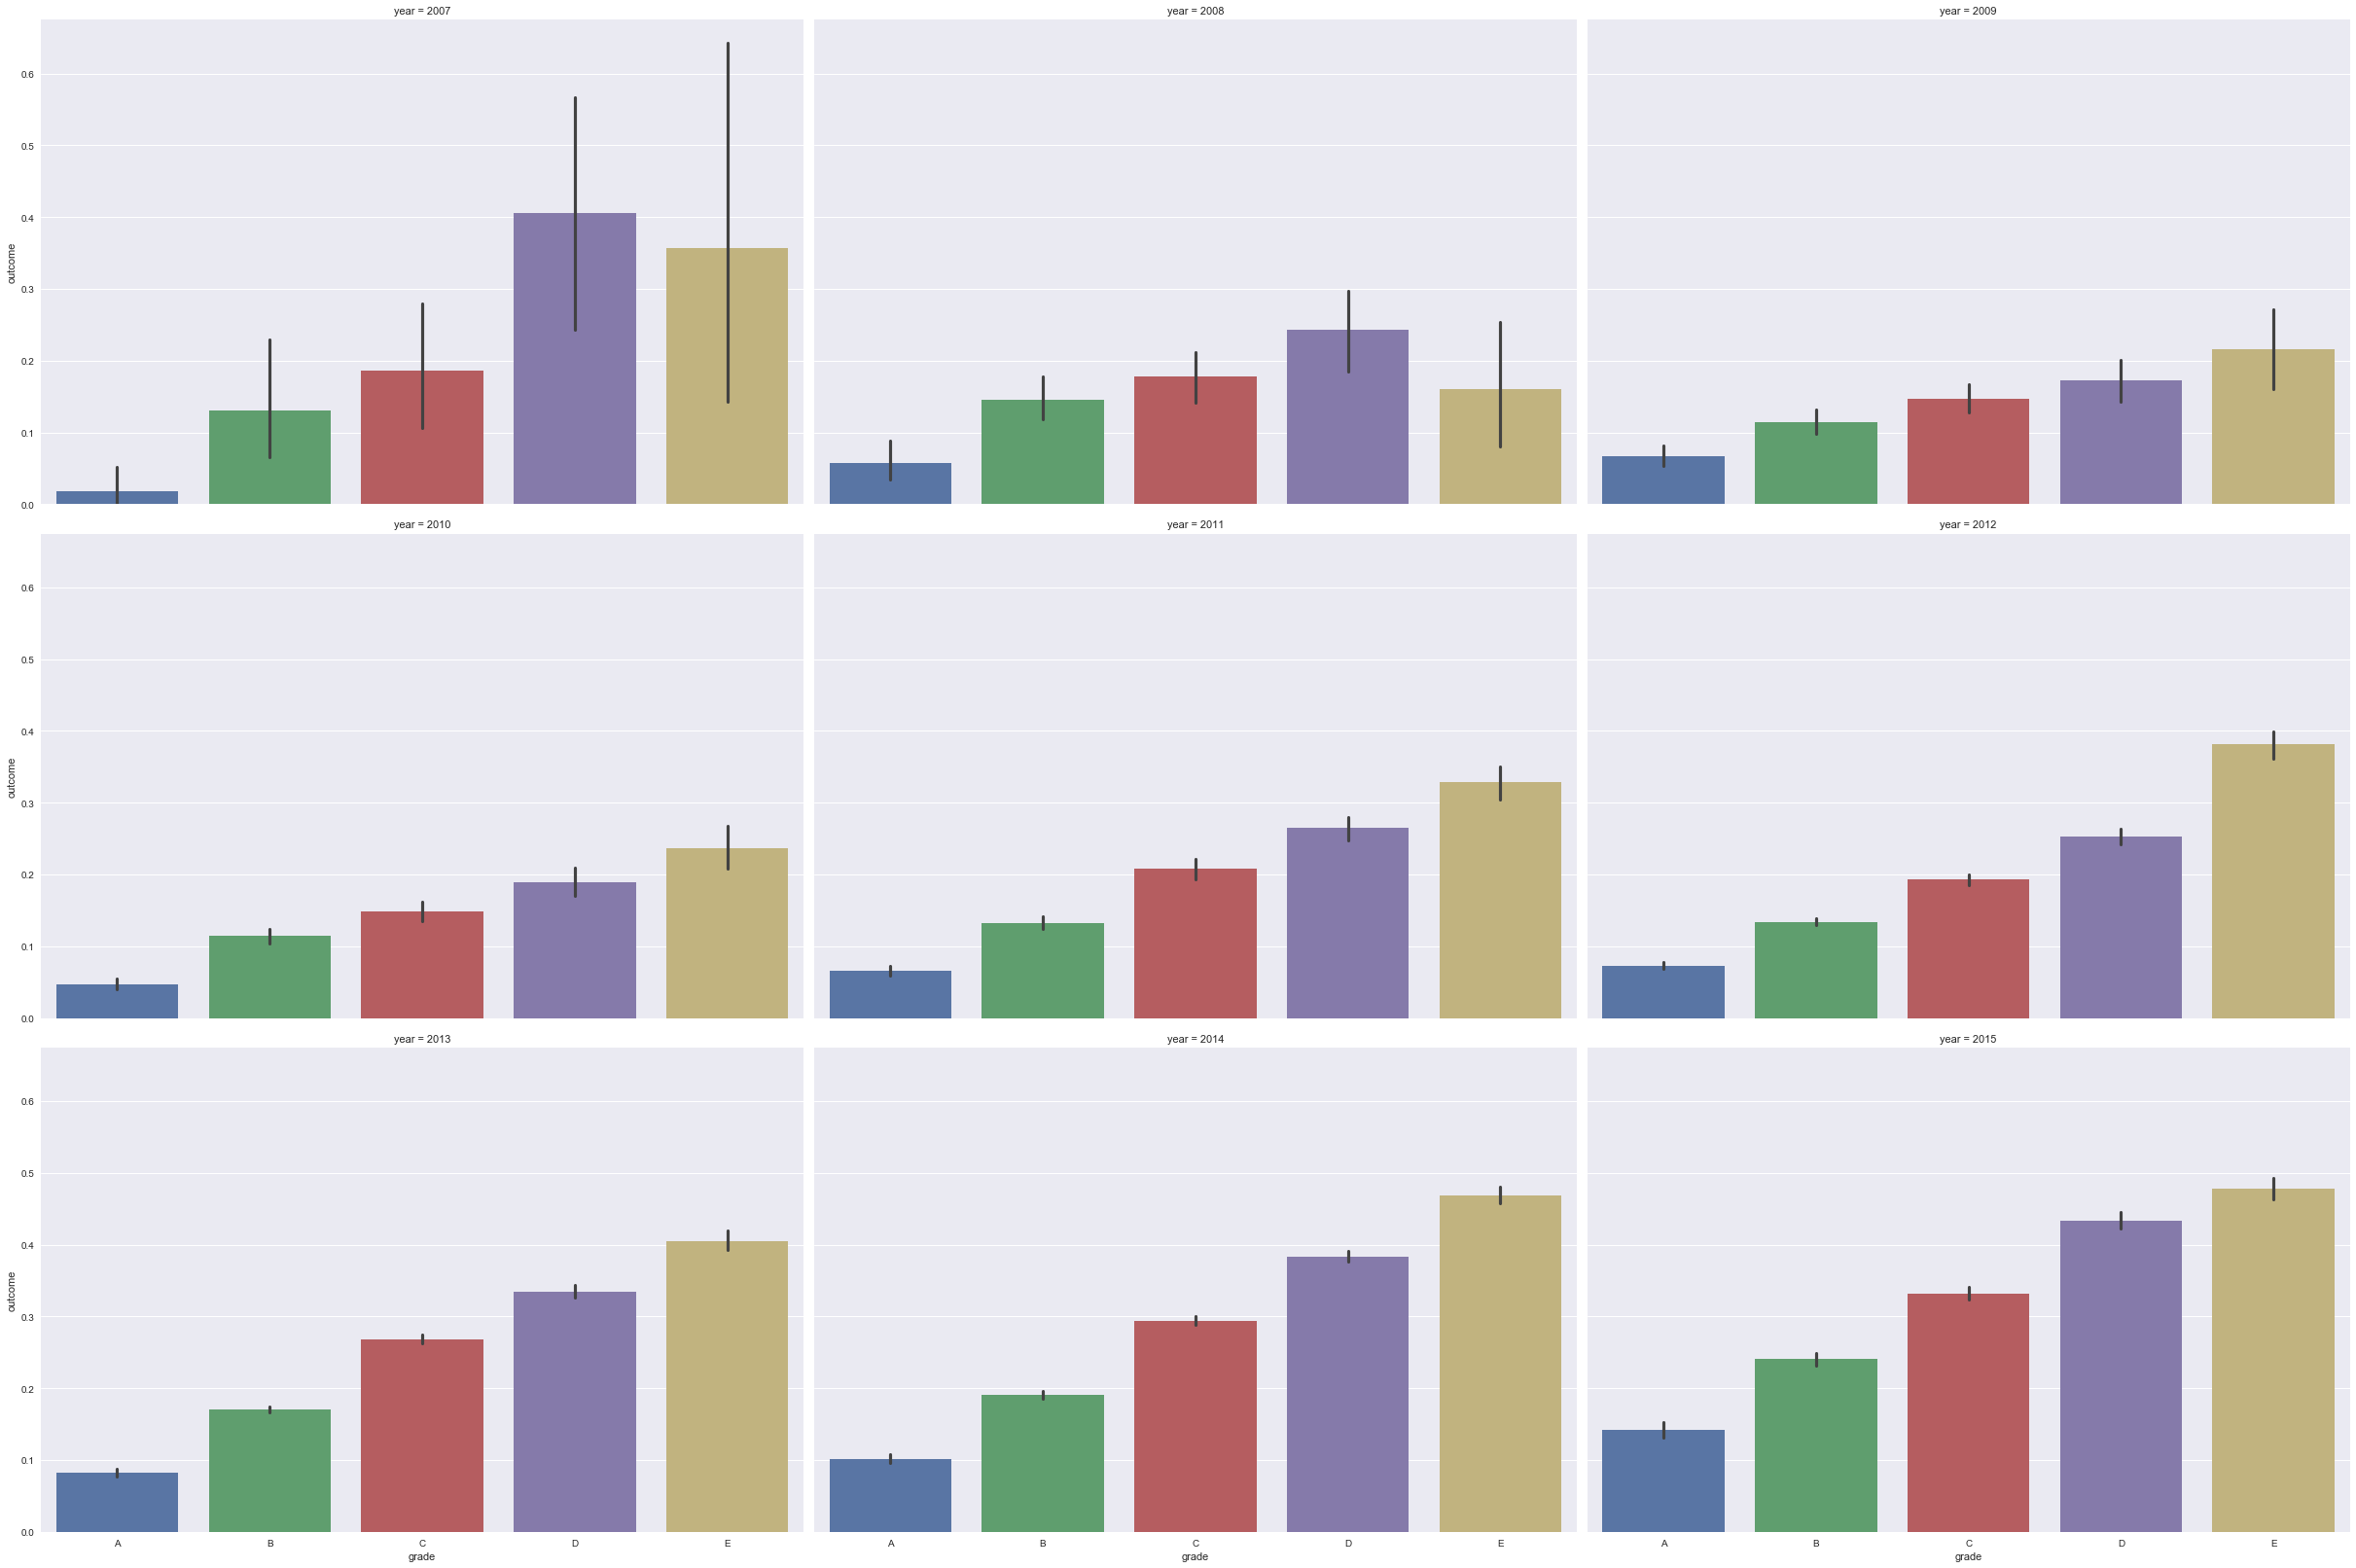

In [158]:

g = sns.factorplot(x='grade', y='outcome', col= 'year', col_wrap=3,
                   data=loans_outcome, kind='bar', 
                   order=['A', 'B', 'C','D', 'E'],
                   size=7.5, aspect=1.5)

The plots above show the default rate for each grade and year. In the years 2007 and 2008 the default rate for grade E was less than the default rate for grade D.This may be because as Lending Club was launched in the year 2006,the model used for grading loans needed to be refined further. In the years following, the default rate corresponds well with the grade indicating that the 
system used by lending club to grade the loans has been effective in predicting the chance of a loan defaulting quite well. 

## Predictive Strength of each feature on the rate of default.

In order to build  a model we will now investigate how each feature relates to the default rate. By doing so we may be able to pick out the features that are likely to be useful in the model vs. those that are not. 

The bar graphs below show the rate of default for each feature by year  at the different levels of the feature. 


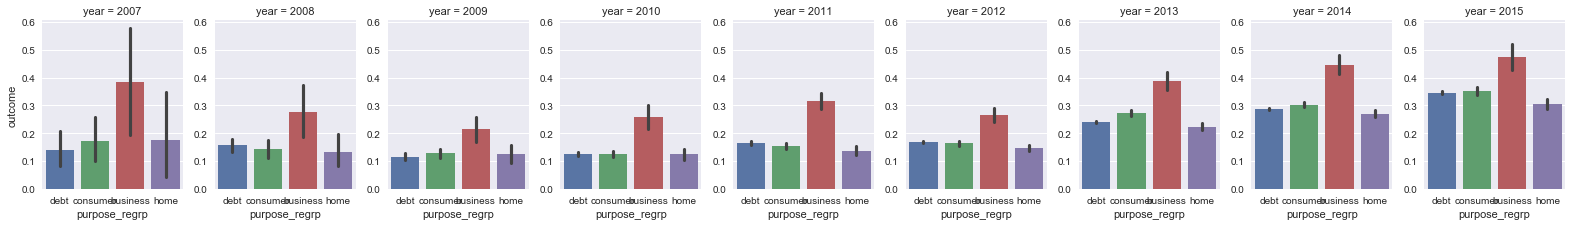

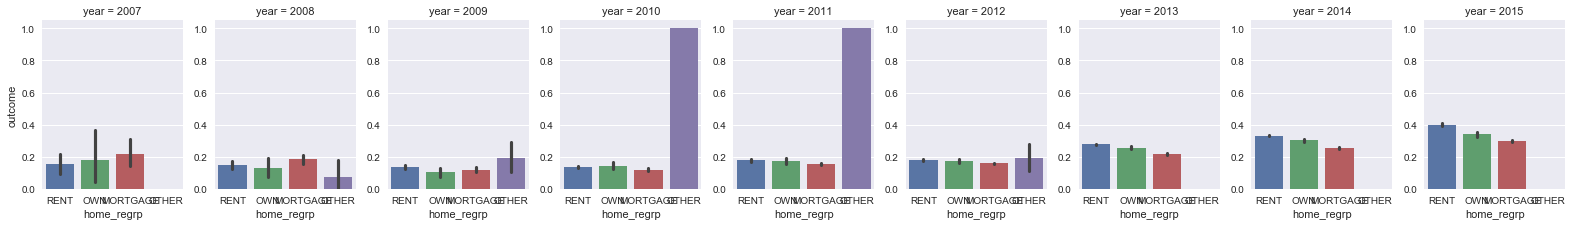

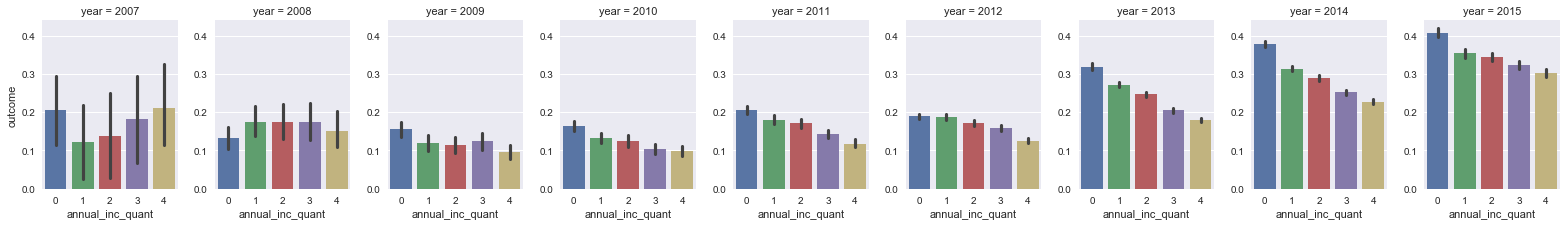

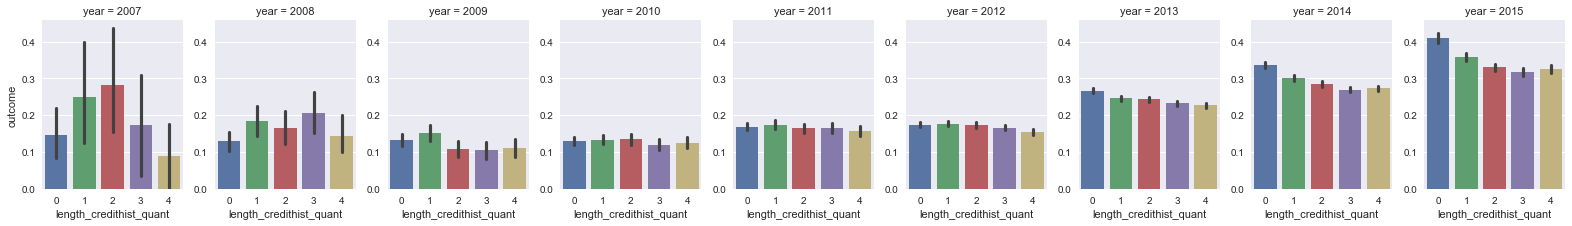

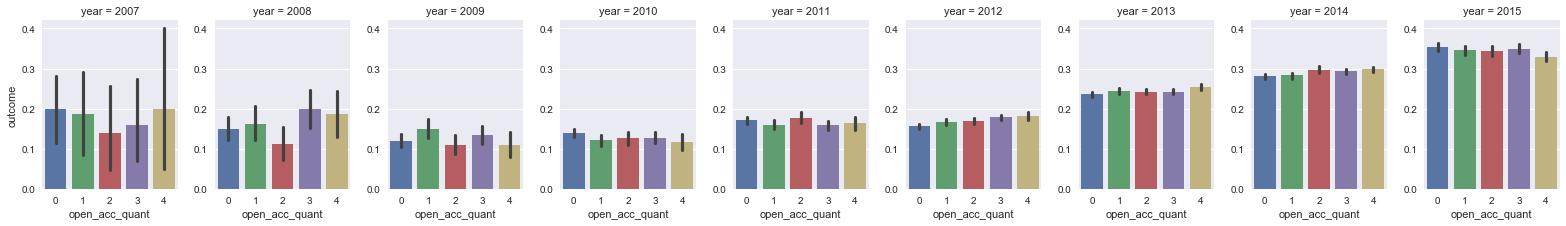

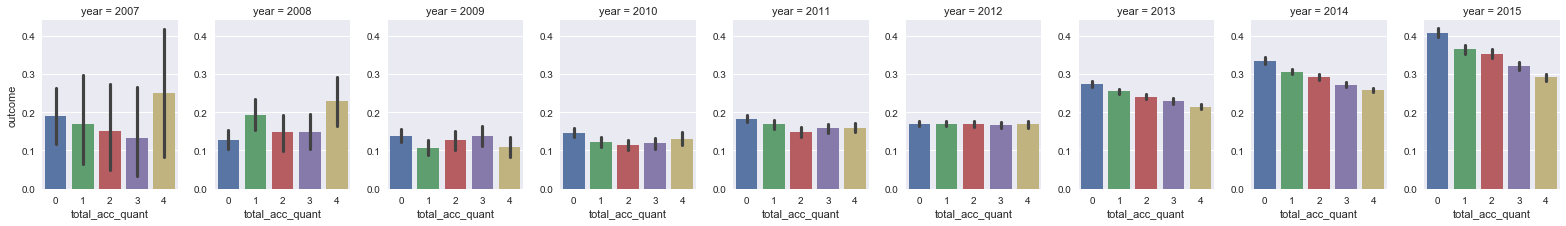

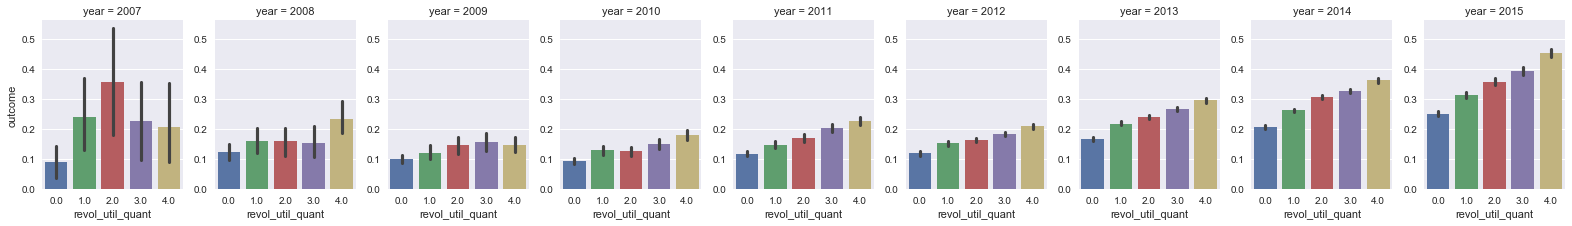

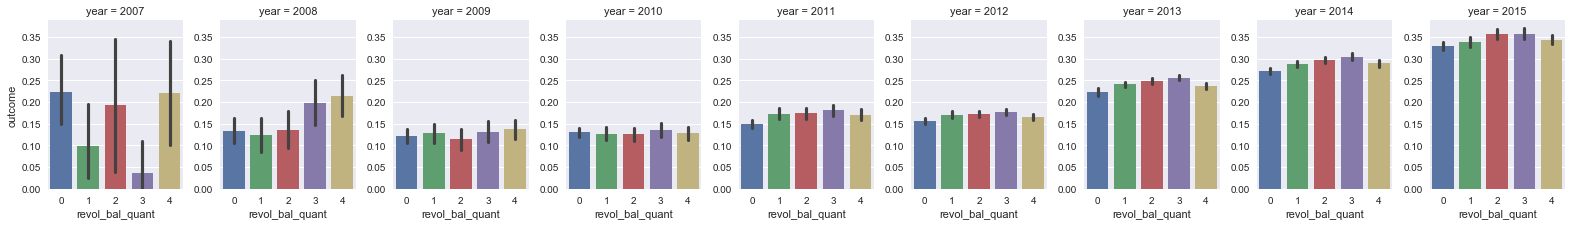

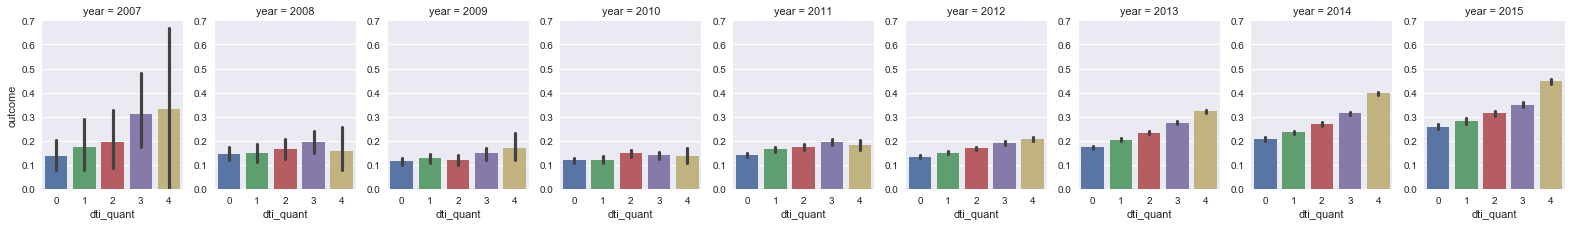

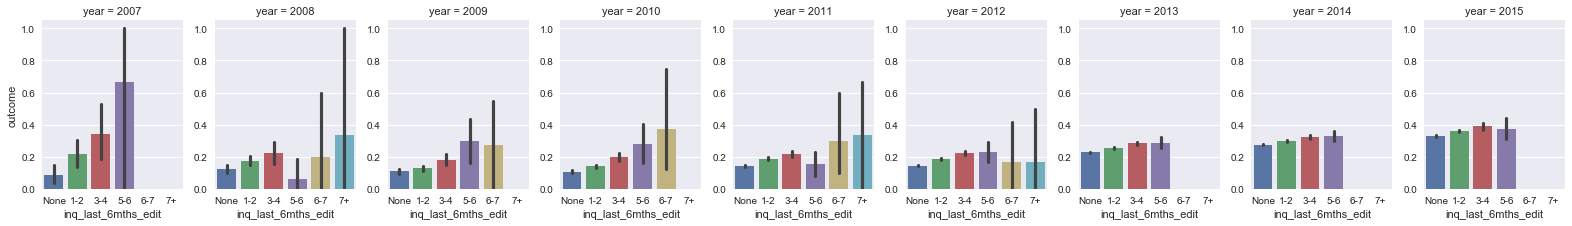

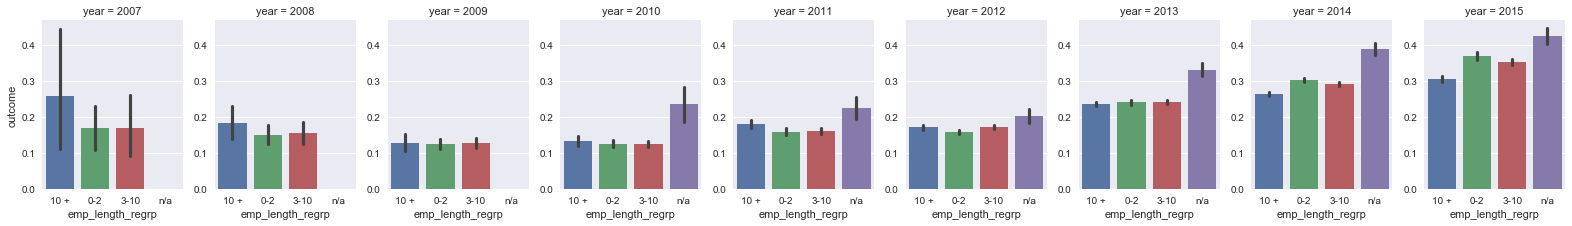

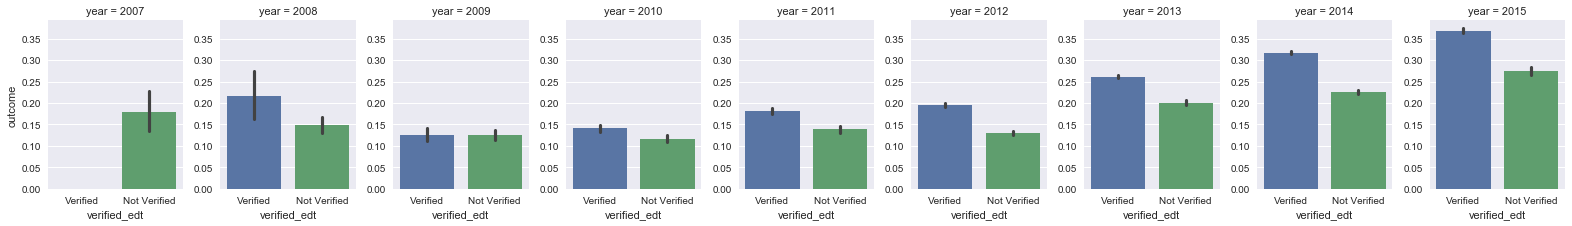

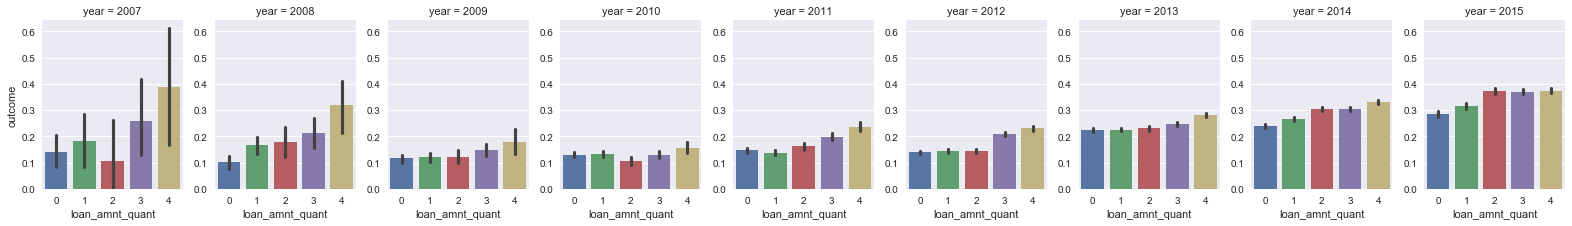

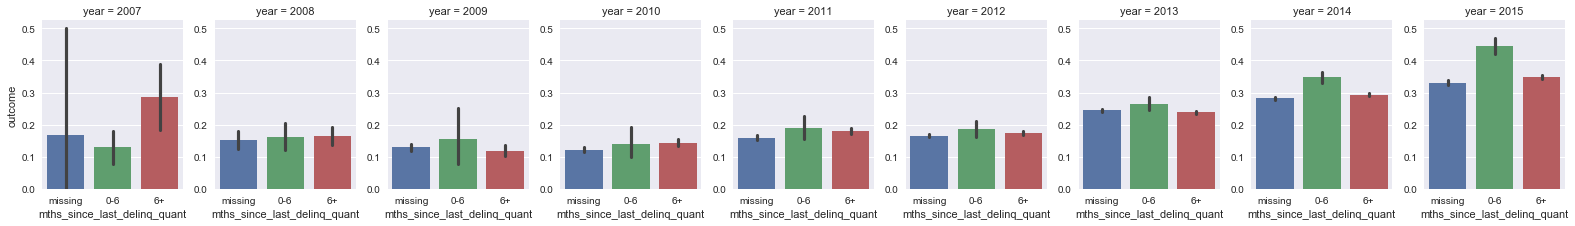

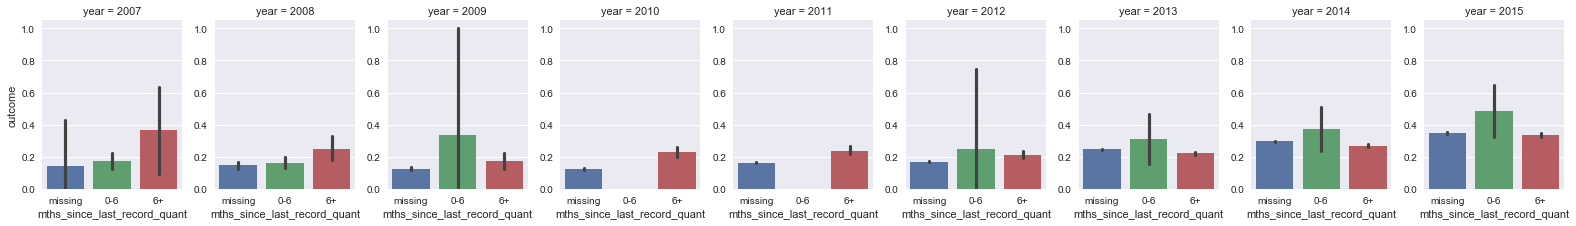

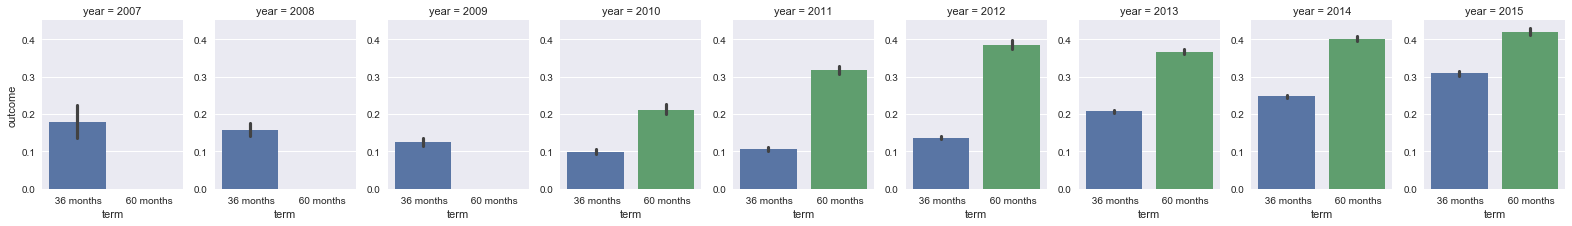

In [159]:
cols_to_plot1 =[ 'purpose_regrp', 'home_regrp', 'annual_inc_quant','length_credithist_quant','open_acc_quant',
              'total_acc_quant','revol_util_quant','revol_bal_quant','dti_quant','inq_last_6mths_edit','emp_length_regrp',
               'verified_edt','loan_amnt_quant', 'mths_since_last_delinq_quant','mths_since_last_record_quant','term']
              


for i in cols_to_plot1:
    g = sns.factorplot(x=i, y='outcome',   col='year', 
                   data=loans_outcome, kind='bar', 
                   
                   size=3.25, aspect=0.75)
  
    
    

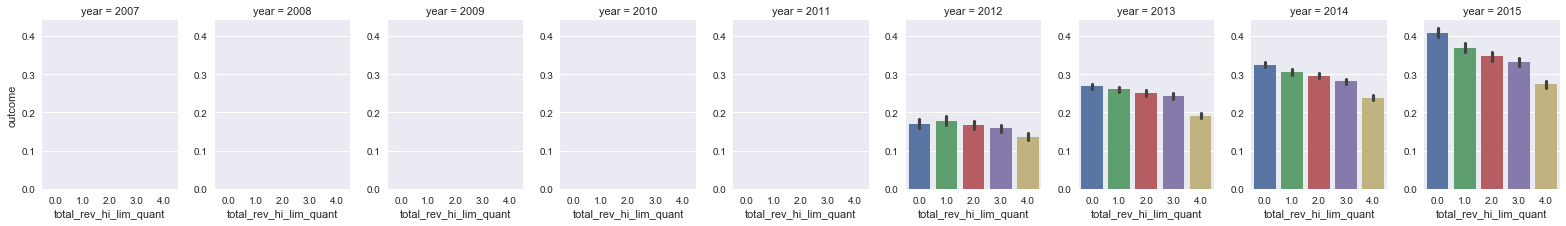

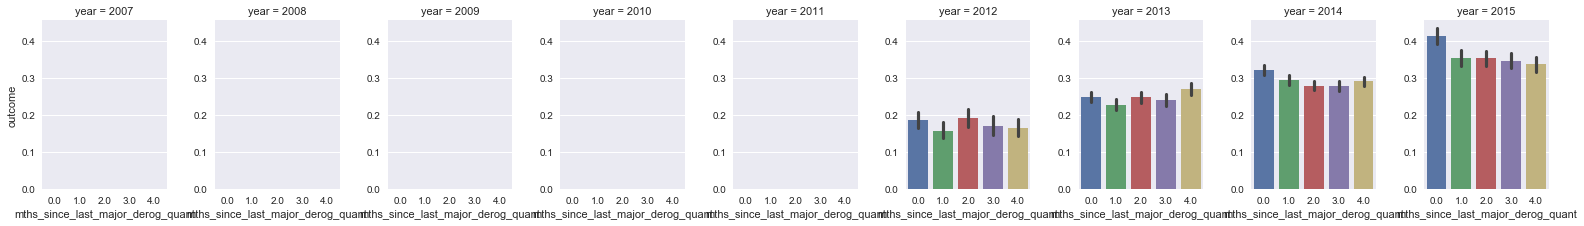

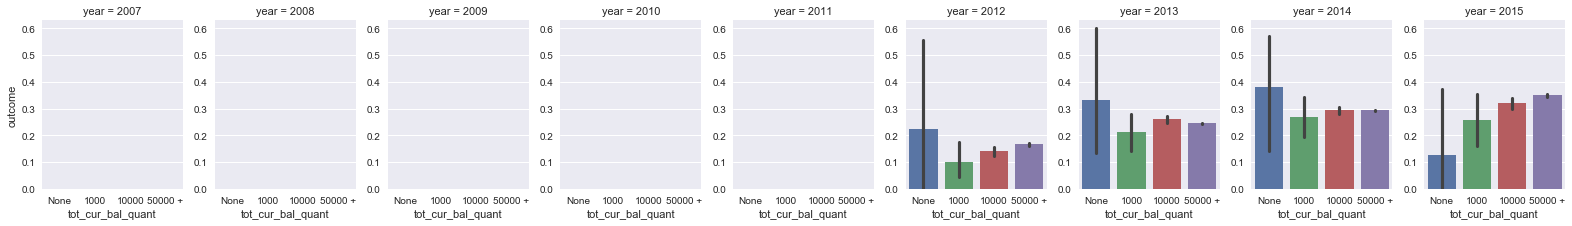

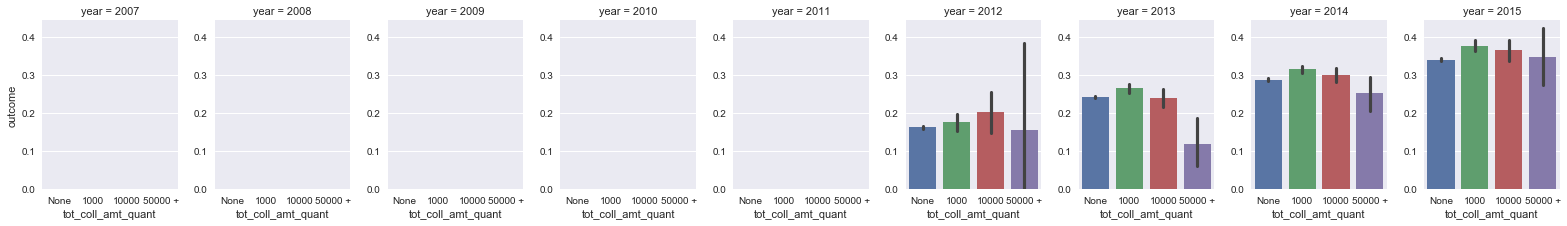

In [160]:
cols_to_plot2 =[  'total_rev_hi_lim_quant','mths_since_last_major_derog_quant', 'tot_cur_bal_quant','tot_coll_amt_quant']
            

for i in cols_to_plot2:
    g = sns.factorplot(x=i, y='outcome',  col='year', 
                   data=loans_outcome, kind='bar', 
                   size=3.25, aspect=0.75)

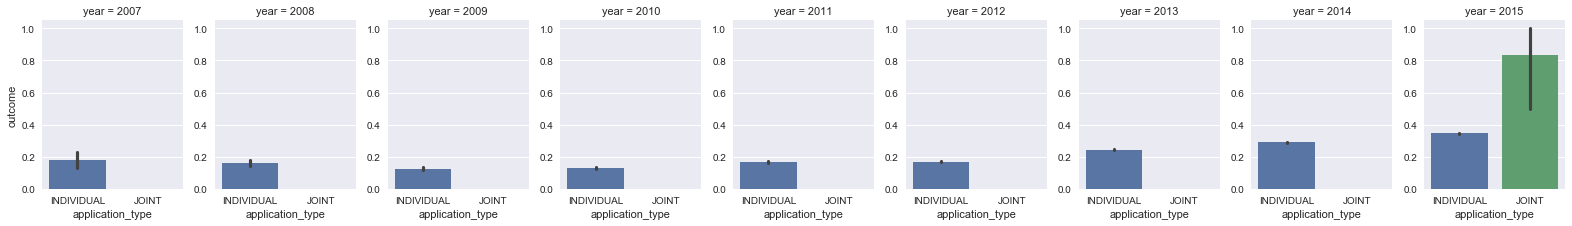

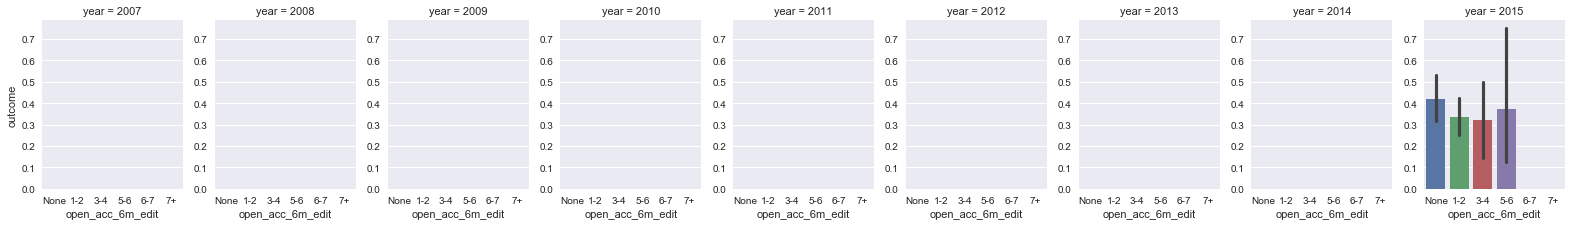

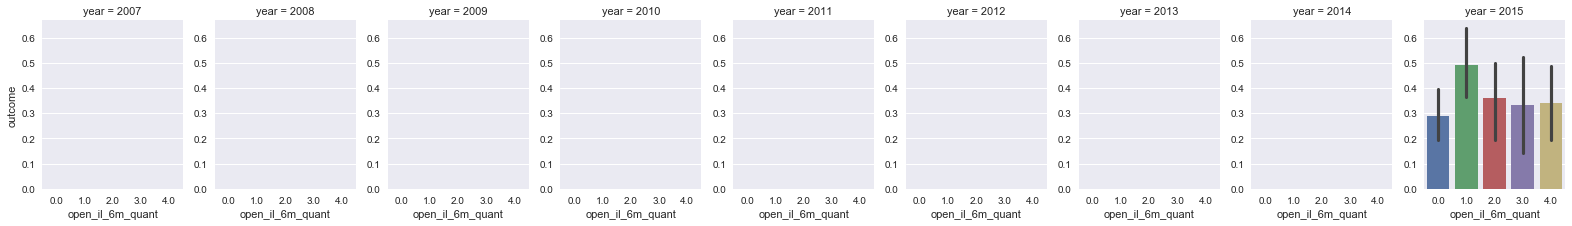

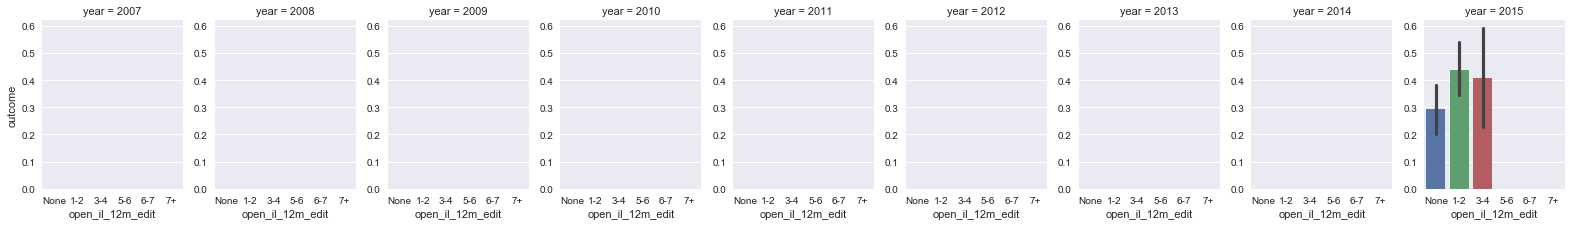

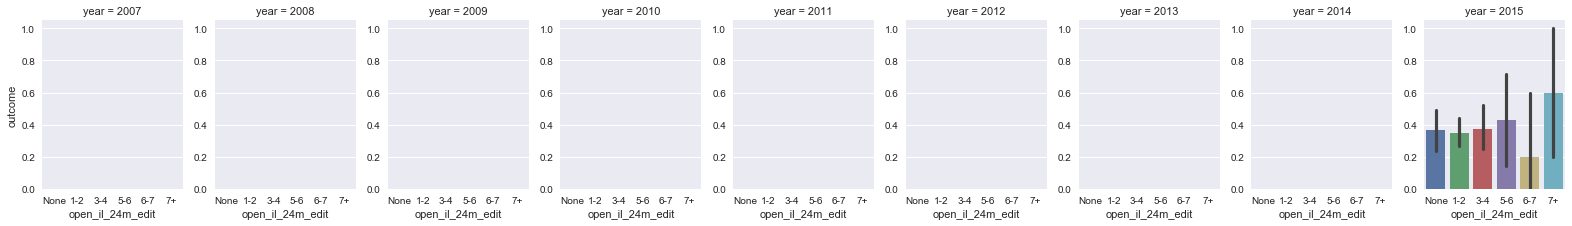

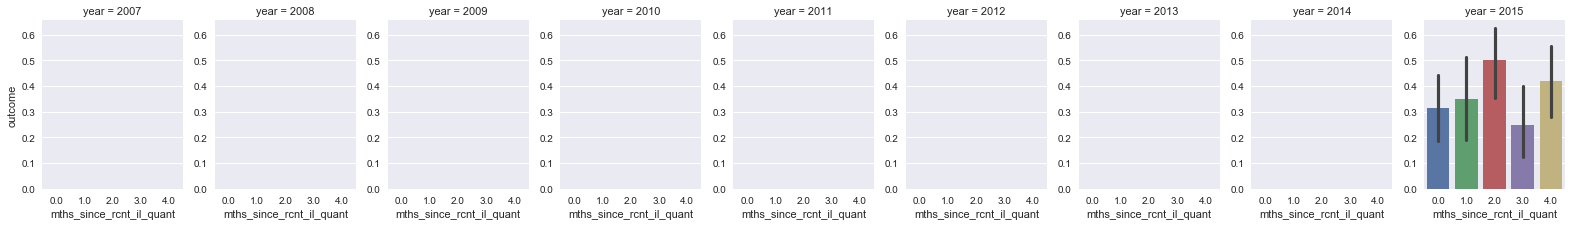

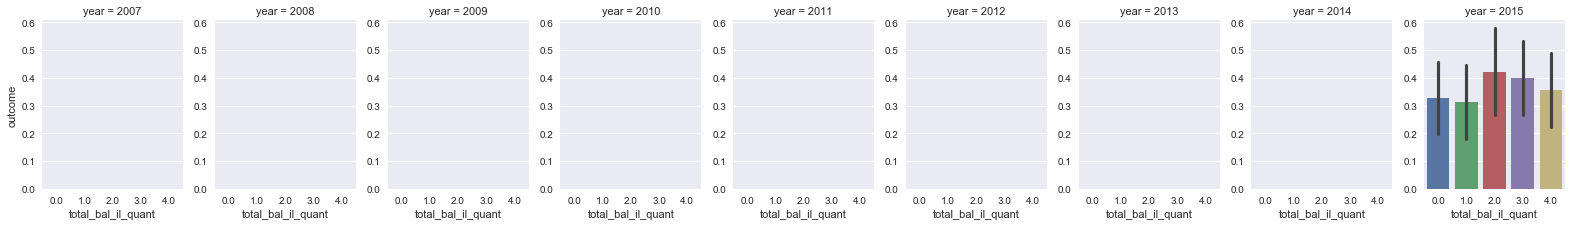

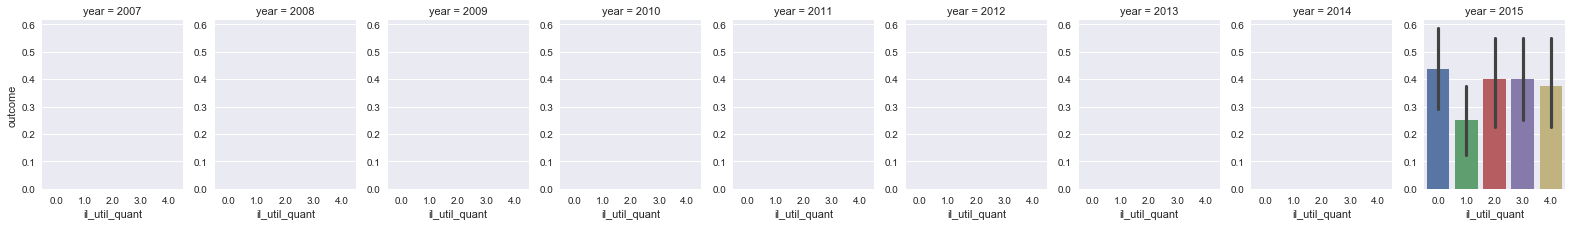

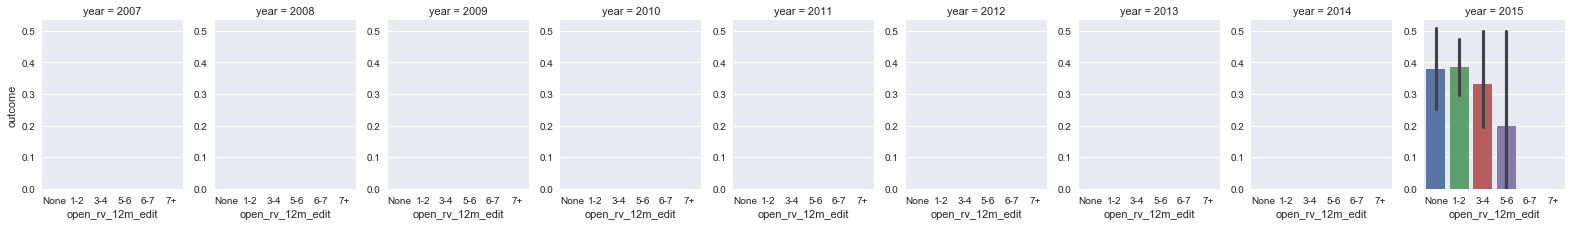

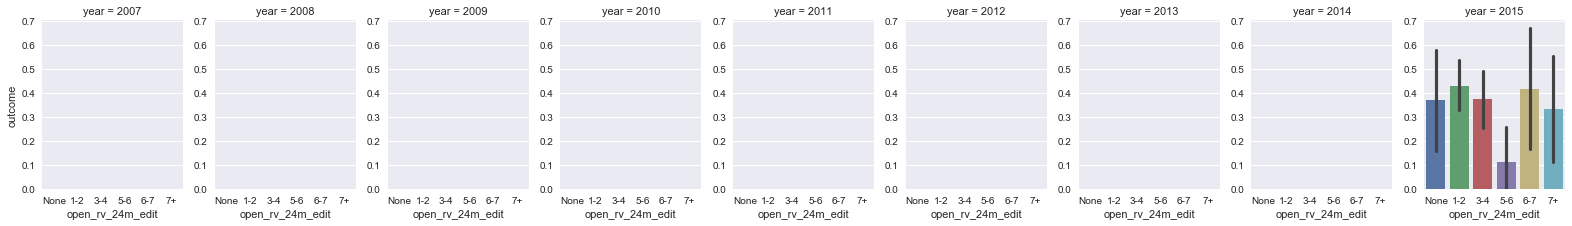

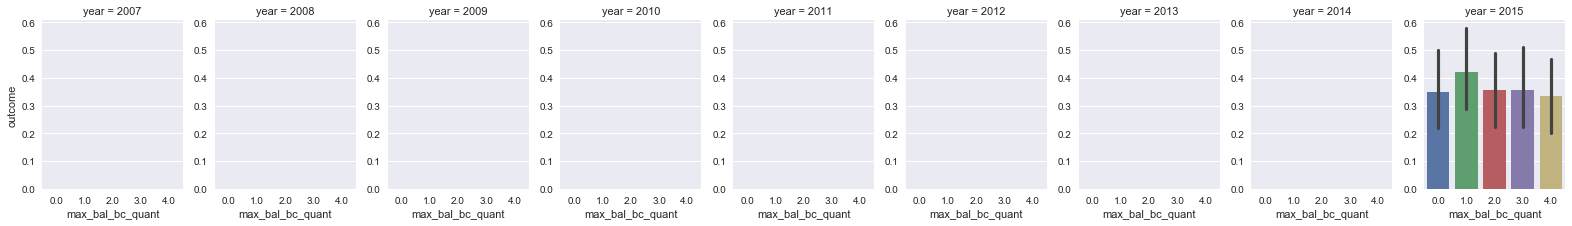

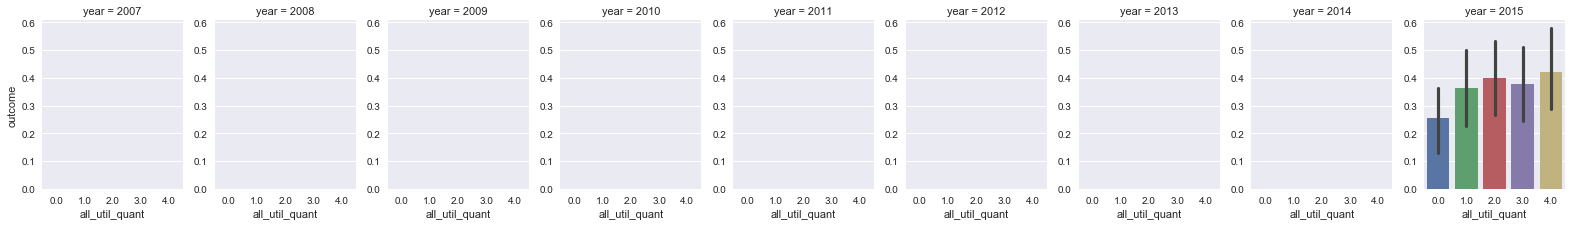

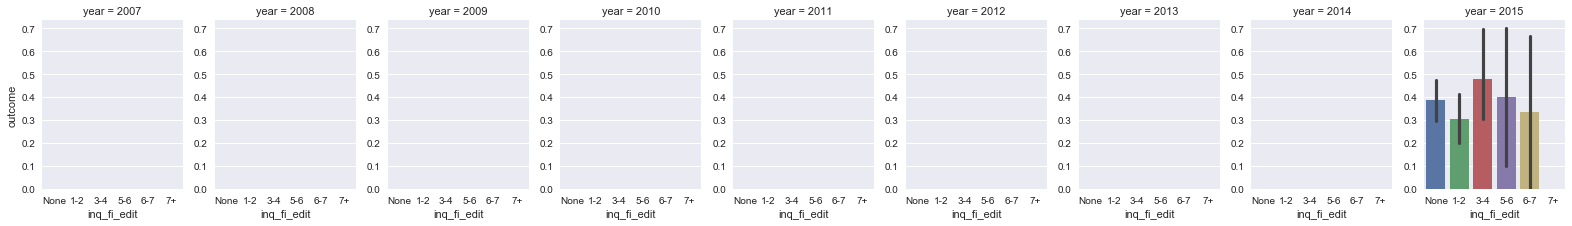

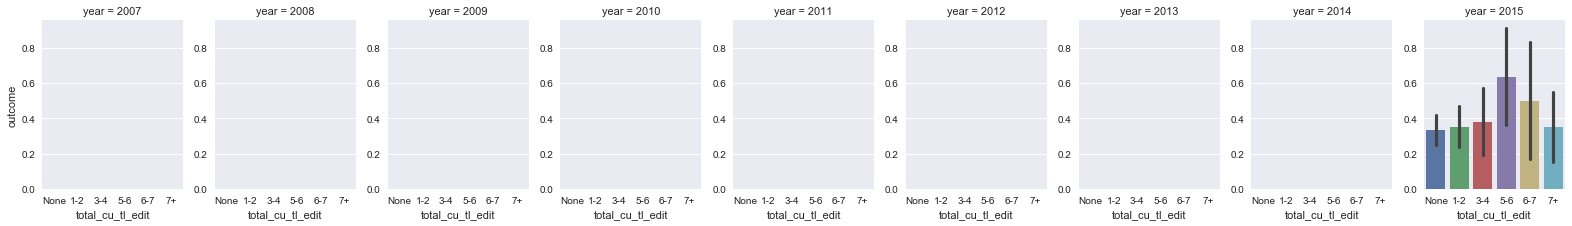

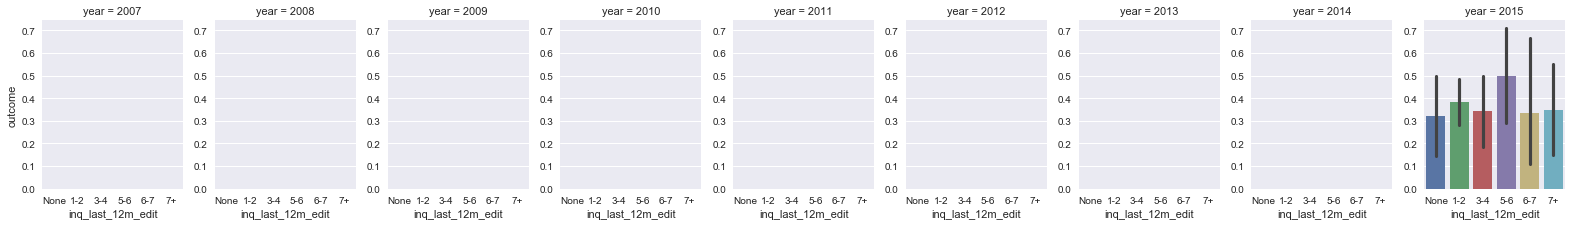

In [161]:
cols_to_plot3 =['application_type','open_acc_6m_edit','open_il_6m_quant',
               'open_il_12m_edit','open_il_24m_edit','mths_since_rcnt_il_quant','total_bal_il_quant','il_util_quant',
               'open_rv_12m_edit','open_rv_24m_edit','max_bal_bc_quant','all_util_quant', 'inq_fi_edit','total_cu_tl_edit','inq_last_12m_edit']


for i in cols_to_plot3:
    g = sns.factorplot(x=i, y='outcome',  col='year', 
                   data=loans_outcome, kind='bar', 
                   size=3.25, aspect=0.75)

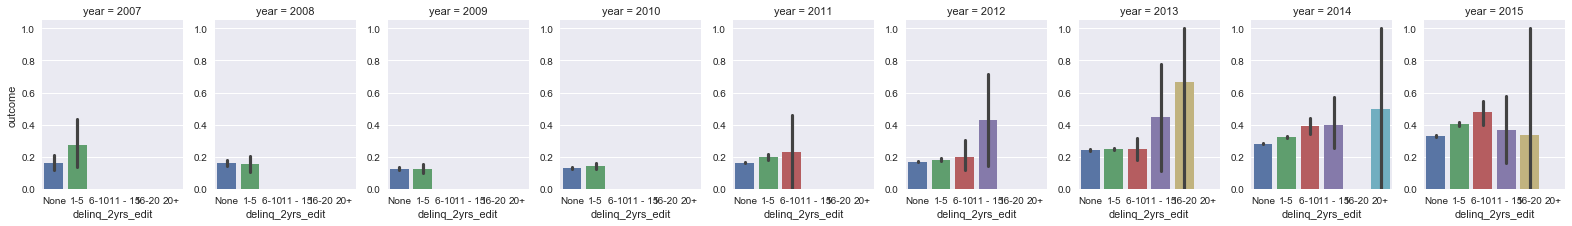

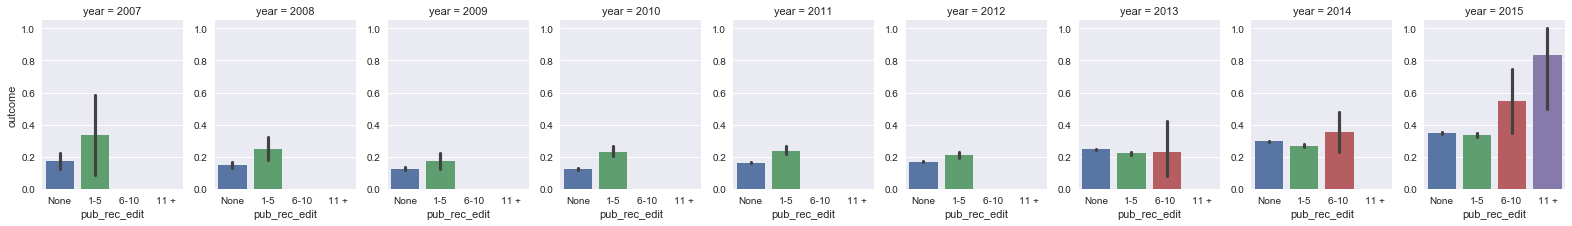

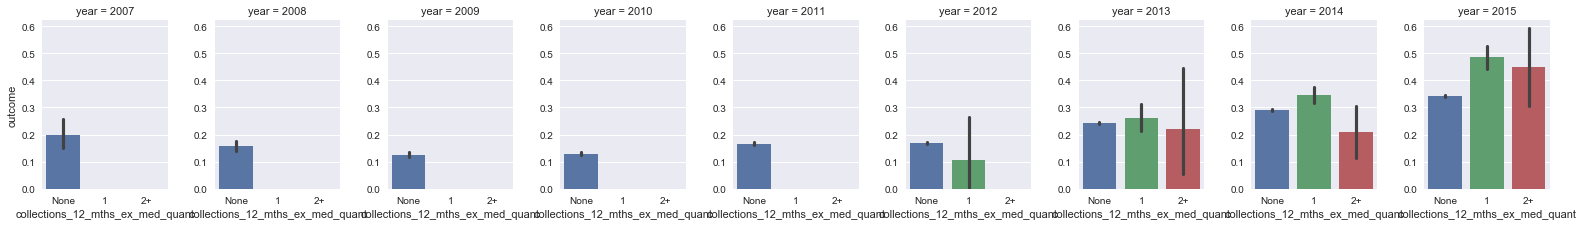

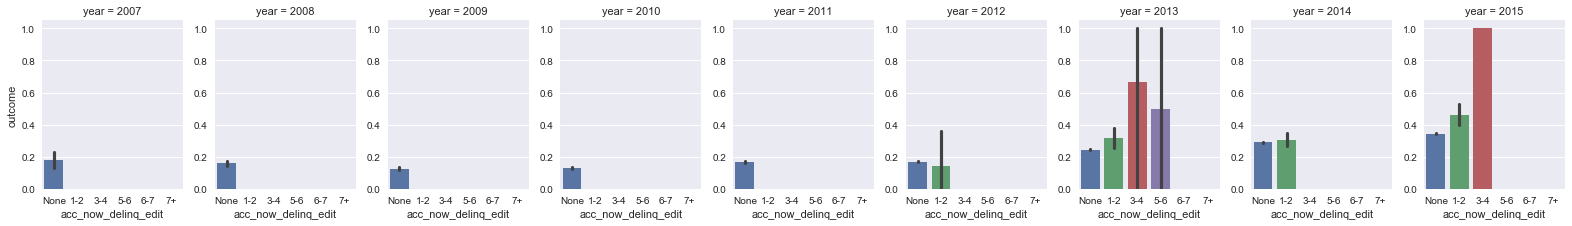

In [162]:
cols_to_plot4 =['delinq_2yrs_edit', 'pub_rec_edit','collections_12_mths_ex_med_quant',  'acc_now_delinq_edit']


for i in cols_to_plot4:
    g = sns.factorplot(x=i, y='outcome',   col='year', 
                   data=loans_outcome, kind='bar', 
                   
                   size=3.25, aspect=0.75)
  
    

#### From the bar charts looking at rate of default vs each feature by year we see:

1. Use only the data from 2010-1015 as the data from 2007 -2009 has a lot of variabilty.
2. Drop the attributes present only in the year 2015. 
3. Drop the attributes only available from 2012( total_rev_hi_lim, tot_cur_bal, tot_coll_amnt, mths_since_last_major_derog,   acc_now_delinq, collections_12mths_ex_med)as they are available only form 2012 on and does not show high predictive strength.
4. Drop acc_now_delinq: up until 2011 no delinquent accounts and in 2012 only one loan grade had some. So deliquent account activity present only for 2013-2015. So will not keep this feature.
5. Note: total_rev_hi_lim is present only from 2012 but shows potential predictive ability but is not included.

In the code that follows we will re-bin the following attributes based on similarity in default rates.
1. For the attributes mths_since_last_delinq_quant and mths_since_last_record_quant include the category "missing" with the 6+. 
2. For home_regrp include the category "OTHER" with the "Rent" group.
3. length_credithist_quant group quantiles 3 and 4.
4. Emp_length_regrp as "na", "0-10" and "10+"
5. loan_amount group quantiles 0 +1 and bins 2+3+4
6. delinq_2yrs_none_any ( two categories: no delinquencies vs atleast one)

We  also need to explore the predictive strength of addr_state( the state the loan was issued in). 

In [163]:

loans_outcome.loc[:, 'mths_since_last_record_quant'].replace(['missing'], ['6+'], inplace=True)

In [164]:

loans_outcome.loc[:, 'mths_since_last_delinq_quant'].replace(['missing'], ['6+'], inplace=True)

In [165]:

loans_outcome.loc[:, 'home_regrp'].replace(['OTHER'], ['RENT'], inplace=True)


In [166]:

loans_outcome.loc[:, 'length_credithist_quant'].replace([4], [3], inplace=True)

In [167]:



loans_outcome.loc[:, 'emp_length_regrp'].replace(['0-2', '3-10'], ['0-10', '0-10'], inplace=True)

In [168]:

loans_outcome.loc[:, 'loan_amnt_quant'].replace([0, 3, 4], [1, 2, 2], inplace=True)

In [169]:
#delinq_2yrs_none_any : make two categories. 0 ='None' 1 or more= 'Past Due'
bins = [-1, 0.9, 40]

group_names = ['None', 'Past Due']

loans_outcome['delinq_2yrs_none_any'] = pd.cut(loans_outcome['delinq_2yrs'], bins, labels=group_names)

###### Take a look at the changes

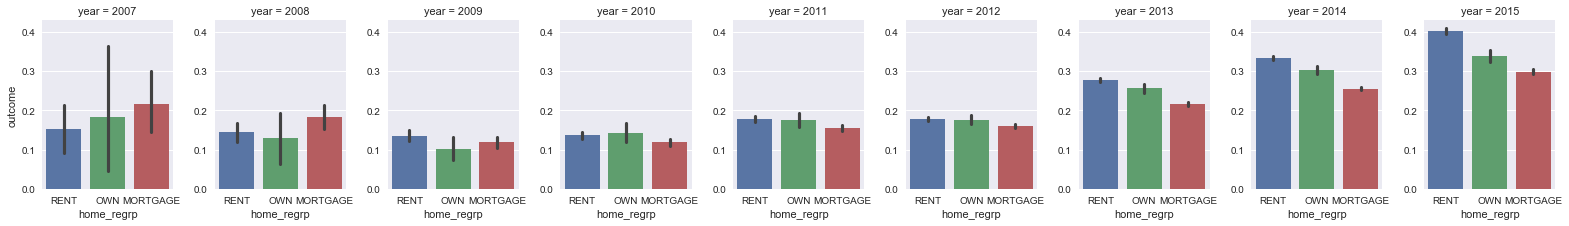

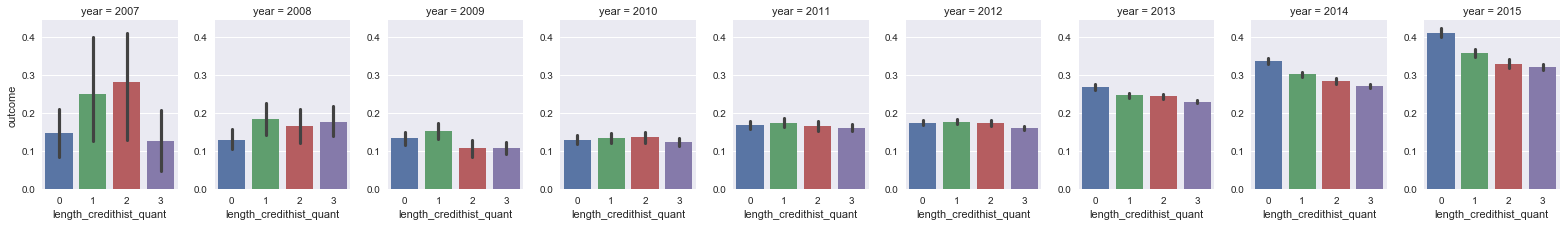

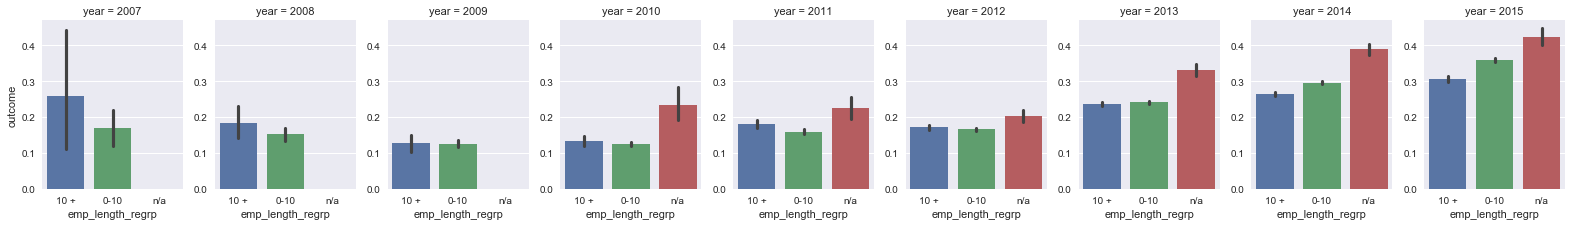

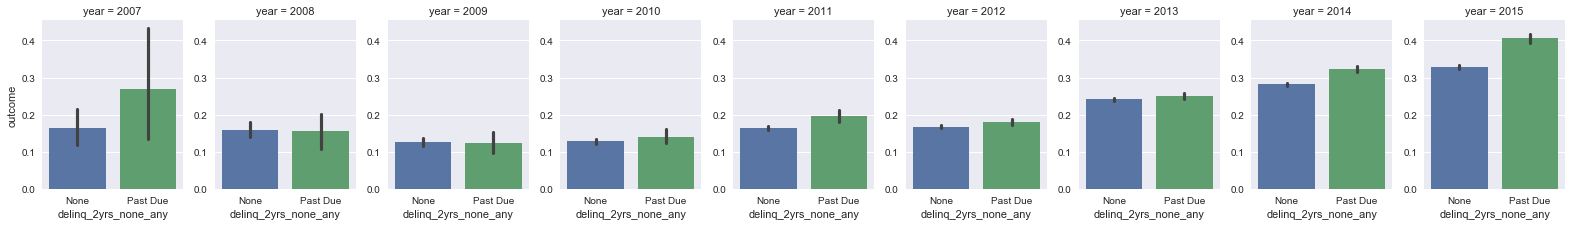

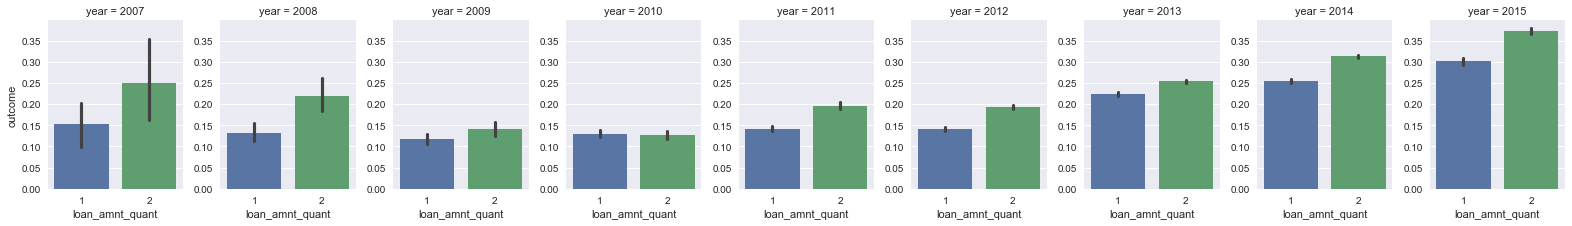

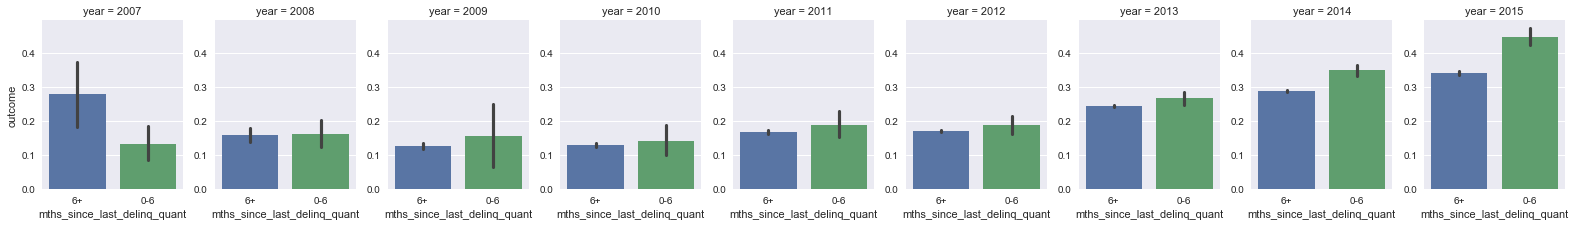

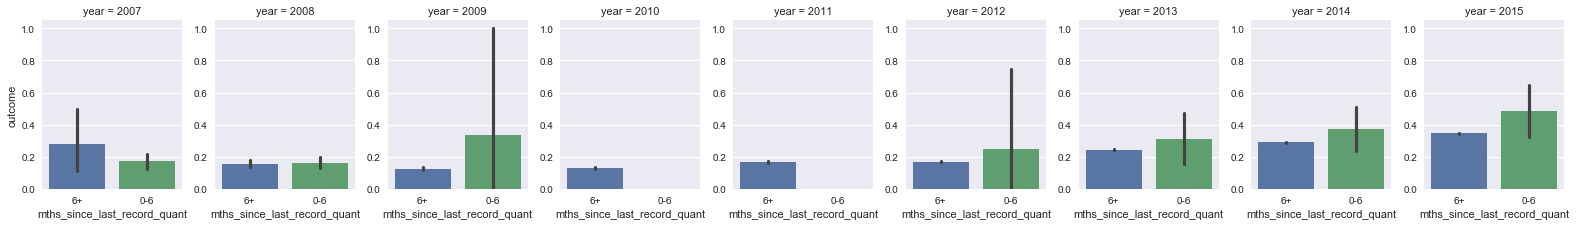

In [170]:
cols_to_plot5 =[ 'home_regrp', 'length_credithist_quant','emp_length_regrp','delinq_2yrs_none_any',
               'loan_amnt_quant', 'mths_since_last_delinq_quant','mths_since_last_record_quant']
              


for i in cols_to_plot5:
    g = sns.factorplot(x=i, y='outcome',   col='year', 
                   data=loans_outcome, kind='bar', 
                   
                   size=3.25, aspect=0.75)

#### Influence of State on default rate : 
   The attribute "addr_state" gives the state where the loan was issued. We will explore the default rate in relation to state by plotting the default rate per state in a choropleth heat map. 
  
We can see below, that the states IN, TN, MS, NE and ND have the highest default rate. Greater than 30%. We will group these states as High and the rest as low by creatig a new feature called 'state_high_low'

In [171]:
# calculate percent default by state
outcome_pcts=loans_outcome.groupby(['addr_state'])['outcome'].agg( ['count', 'mean']).reset_index()


In [172]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

df = outcome_pcts

for col in df.columns:
    df[col] = df[col].astype(str)

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

df['text'] = df['addr_state'] + '<br>' +\
    'Default :'  +  df['mean'] +'<br>'+\
     'Total Loan Count: '+df['count']


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = df['addr_state'],
        z = df['mean'], 
        locationmode = 'USA-states',
        text = df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "% Default")
        ) ]


layout = dict(
        title = ' Default Rate By State <br> (Hover over state for loan counts)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
iplot( fig, filename='d3-choropleth-map' )


In [173]:
loans_outcome["state_outcome"] = loans_outcome.groupby('addr_state')["outcome"].transform('mean')

loans_outcome['addr_state'].loc[(loans_outcome["state_outcome"] >0.30)].value_counts()

IN    3128
TN    2782
MS     532
NE      55
ND      12
Name: addr_state, dtype: int64

In [174]:
#groups states by default rate greater than 0.30 and less than 0.30
bins = [-1.0, 0.30, 1]
group_names = ['low', 'high']
loans_outcome['state_high_low'] = pd.cut(loans_outcome['state_outcome'], bins, labels=group_names)

## Relevant Years and Features for Model Building

Looking at  the bar graphs, evident is the variability present in the data for the years 2007 and 2008. The data collected in 2007 and 2008 reflect the fact that lending club was in its early stages and its loan approval strategy had room for improvement. The trends from 2009 onwards appears to be more stable. For our model we will keep only the data from 2009 and drop 2007 and 2008.

In [175]:
years_to_keep =['2010', '2011', '2012', '2013', '2014', '2015']
loans_outcome=loans_outcome.loc[loans_outcome['year'].isin(years_to_keep)]
loans_outcome.year.unique()

[2011, 2010, 2013, 2012, 2014, 2015]
Categories (6, int64): [2011, 2010, 2013, 2012, 2014, 2015]

##### Only keep columns  that will  be used as features in the model.

In [176]:
cols_to_keep =['outcome', 'purpose_regrp', 'home_regrp', 'annual_inc_quant', 'length_credithist_quant','open_acc_quant',
              'total_acc_quant','revol_util_quant','revol_bal_quant','dti_quant','inq_last_6mths_edit','emp_length_regrp',
              'verified_edt','loan_amnt_quant', 'mths_since_last_delinq_quant','mths_since_last_record_quant',
              'term','delinq_2yrs_none_any', 'pub_rec_edit', 'state_high_low']

loans_outcome= loans_outcome[[i for i in loans_outcome.columns if i  in cols_to_keep]]


In [177]:
loans_outcome.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267862 entries, 0 to 887371
Data columns (total 20 columns):
term                            267862 non-null object
outcome                         267862 non-null int64
purpose_regrp                   267862 non-null object
home_regrp                      267862 non-null object
emp_length_regrp                267862 non-null object
verified_edt                    267862 non-null object
length_credithist_quant         267862 non-null int64
annual_inc_quant                267862 non-null int64
dti_quant                       267862 non-null int64
revol_bal_quant                 267862 non-null int64
revol_util_quant                267671 non-null float64
total_acc_quant                 267862 non-null int64
open_acc_quant                  267862 non-null int64
loan_amnt_quant                 267862 non-null int64
inq_last_6mths_edit             267862 non-null category
mths_since_last_record_quant    267862 non-null object
mths_since_las

####  Look at correlations between columns : 
Machine learning methods are usually robust in the presence of correlated predictors. However understanding the degree to which predictors are correlated is useful to better understand the relationship between the features with each other and with the outcome. Here we will obtain the correlations between the numeric features.

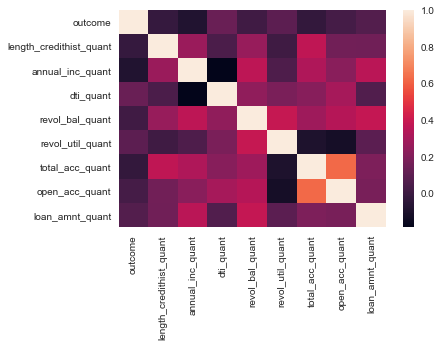

In [178]:
sns.heatmap(loans_outcome.corr())

In [179]:
cor = loans_outcome.corr()
cor.loc[:,:] = np.tril(cor, k=-1) # below main lower triangle of an array
cor = cor.stack()
cor[(cor > 0.55) | (cor < -0.55)]

open_acc_quant  total_acc_quant    0.624108
dtype: float64

total_acc and open_acc_quant have a correlation of 0.62. Do we keep one or both?
total_acc is the total number of credit lines currently in the borrower's credit file open_acc is the the number of open credit lines in the borrower's credit file. From the bar graphs plotted earlier total_acc showed a stronger trend with default rate. So we will retain total_acc and drop open_acc.

The correlation of outcome with the features does not seem strong but as expected the annual_inc quantile is negatively correlated  indicating higher the annual income lower the rate of default and dti , teh ratio of debt to income is one of the higher correlated features. We would expect ot see this feature being significant in the predictive model. 

In [180]:

loans_outcome.drop("open_acc_quant", axis=1, inplace=True)

#### Create Dummies

The library “sklearn” requires features to be in numeric arrays. So now we can acheive this by converting the categorical variables
into numeric variables by means of dummy coding. In creating dummy variables, a column is created corresponding 
to each level of the categorical feature where the value equals 1 for those loans that have that partiular level
and zero for all others. 

In [181]:

loans_outcome = pd.get_dummies(loans_outcome)
loans_outcome.info()       

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267862 entries, 0 to 887371
Data columns (total 40 columns):
outcome                             267862 non-null int64
length_credithist_quant             267862 non-null int64
annual_inc_quant                    267862 non-null int64
dti_quant                           267862 non-null int64
revol_bal_quant                     267862 non-null int64
revol_util_quant                    267671 non-null float64
total_acc_quant                     267862 non-null int64
loan_amnt_quant                     267862 non-null int64
term_ 36 months                     267862 non-null uint8
term_ 60 months                     267862 non-null uint8
purpose_regrp_business              267862 non-null uint8
purpose_regrp_consumer              267862 non-null uint8
purpose_regrp_debt                  267862 non-null uint8
purpose_regrp_home                  267862 non-null uint8
home_regrp_MORTGAGE                 267862 non-null uint8
home_regrp_OWN   

#### Missing Values:  
We now need to look at the presence of missing values in the features of interest. Sklearn will not handle missing values left as missing. We either need to drop those rows that have missing values, impute a reasonable value or if there are a lot of missing values for a feature drop the feature. 



In [182]:
missing=loans_outcome.isnull().sum().sort_values(ascending=False)
missing

revol_util_quant                    191
state_high_low_high                   0
purpose_regrp_business                0
emp_length_regrp_0-10                 0
home_regrp_RENT                       0
home_regrp_OWN                        0
home_regrp_MORTGAGE                   0
purpose_regrp_home                    0
purpose_regrp_debt                    0
purpose_regrp_consumer                0
term_ 60 months                       0
state_high_low_low                    0
term_ 36 months                       0
loan_amnt_quant                       0
total_acc_quant                       0
revol_bal_quant                       0
dti_quant                             0
annual_inc_quant                      0
length_credithist_quant               0
emp_length_regrp_10 +                 0
emp_length_regrp_n/a                  0
verified_edt_Not Verified             0
mths_since_last_delinq_quant_0-6      0
delinq_2yrs_none_any_Past Due         0
delinq_2yrs_none_any_None             0


#### Impute Missing Values: 
Only revol_util_quant has any missing values, 191 in total. This is a very small number realtive to the totla number of loans. We could either drop the rows where revol_util_quant is missing or impute. We will impute the median value.

In [183]:
imp = Imputer(missing_values='NaN', strategy= 'median', axis=0)
imp.fit(loans_outcome) 
X = imp.transform(loans_outcome)
loans_imp=pd.DataFrame(X, columns=loans_outcome.columns)


## Prepare the data for Machine Learning algorithms

Now we are ready to create our X and Y variables needed for the machine learning classifiers.
Here we will assign the features to  X and  the outcome to Y. 

In [184]:

X = loans_imp.drop("outcome", axis=1) # drop labels for training set
y= loans_imp["outcome"].copy()

#### Create a Test Set: use stratified sampling by outcome:
Before fitting the model we will set a proportion( 30%) of the data aside for testing. We will use Sklearns train_test_split to split the data into 70%for training ( model fitting) and 30% for testing. By setting the stratify option in train test split to y we are asking that the data be split keeping the same proportion of good to bad loans in the test and the 
training data.

In [185]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.30)

#### Use SMOTE to remedy unbalance
Here we will use SMOTE to remedy the imbalance in our data with respect to the outcome. We have 1/4 the number of bad loans as opposed to 3/4ths good loans. SMOTE synthesizes bad loans in the following manner:

1. Firstly it ignores the majority class observations.( Good loans in our case)
2. Then for every instance of a bad loan it chooses the K nearest neighbors
3. Creates instances halfway between its neighbors and the instance.

For a more detailed explanation on handling of unbalanced data refer to :
https://www.svds.com/learning-imbalanced-classes/

In [186]:
sm = SMOTE(random_state=12, ratio = 'auto')
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [187]:
loans_prepared =pd.DataFrame(X_train_res, columns=X_train.columns)
loans_labels=y_train_res

## Build models by running machine learning algorithms on training data

Now we are ready to use the training data and fit some machine learning models. Whilst there are several possibilities of models that we could use here we will limit ourselves to assesing three of them. 

1. Logistic Regression :

   This is a regression based algorithm where using the features associated with the loan, by fitting the model a probability of    of a loan being a "bad loan" can be obtained. Greater the probability the more likely it is a bad loan. Logistic regression    is the model that has been widely used for credit scoring.
   
   
2. Gradient Boosting: ensemble method based on building weak esitmators that are combined to reduce the bias of the final    estimator.

3. Random Forest: ensemble method based on  averaging decision trees. 


from:http://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting we have the following:
The goal of ensemble methods is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator. 
Two families of ensemble methods are usually distinguished:
In averaging methods, the driving principle is to build several estimators independently and then to average their predictions. On average, the combined estimator is usually better than any of the single base estimator because its variance is reduced.
By contrast, in boosting methods, base estimators are built sequentially and one tries to reduce the bias of the combined estimator. The motivation is to combine several weak models to produce a powerful ensemble.




Now we will use the funtion run_model to fit the models on the training data and choose the classifier has the best metrics to optimize further.The code for the function run_models  was adapted from https://www.kaggle.com/vincepota/predicting-customers-who-will-charge-off

This function:
1. Runs a set of models. 3 in this case: Gradient Boosting, Logistic Regression and Random Forest
2. Makes prediction based on doing Cross Validation on the training data
3. Builds-up a table with evaluation metrics
4. Plots a roc curve of the estimators




In [188]:

def run_models(clfs_dict, X_train, y_train):
    
    clfs = clfs_dict
    
    cols = ['model', 'roc_auc_score', 'precision_score', 'recall_score','f1_score']

    models_report = pd.DataFrame(columns = cols)
    conf_matrix = dict()
    

    for clf, clf_name in zip(clfs.values(), clfs.keys()):

        clf.fit(X_train, y_train)

        y_train_pred = cross_val_predict(clf, X_train, y_train, cv=3)
        
        y_train_score = cross_val_predict(clf, X_train, y_train, cv=3, method="predict_proba")[:,1]

        

        tmp = pd.Series({
                         'model': clf_name,
                         'roc_auc_score' : metrics.roc_auc_score(y_train, y_train_score),
                         
                         'precision_score': metrics.precision_score(y_train, y_train_pred),
                         'recall_score': metrics.recall_score(y_train, y_train_pred),
                         'f1_score': metrics.f1_score(y_train, y_train_pred)})

        models_report = models_report.append(tmp, ignore_index = True)
        conf_matrix[clf_name] = pd.crosstab(y_train, y_train_pred, rownames=['True'], colnames= ['Predicted'], margins=False)
        fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_score, drop_intermediate = False, pos_label = 1)

        plt.figure(1, figsize=(6,6))
        plt.xlabel('false positive rate')
        plt.ylabel('true positive rate')
        plt.title('ROC curve')
        plt.plot(fpr, tpr, label = clf_name )
        plt.legend(loc=2, prop={'size':11})
    plt.plot([0,1],[0,1], color = 'black')
    
    return models_report, conf_matrix

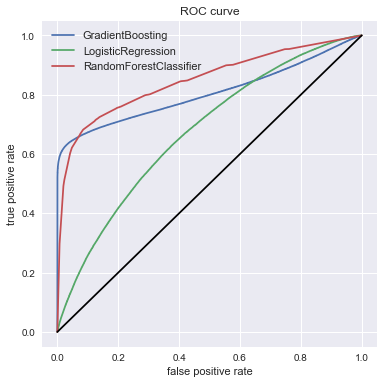

In [189]:
clfs ={'GradientBoosting': GradientBoostingClassifier(max_depth= 6, n_estimators=100, max_features = 0.3),
            'LogisticRegression' : LogisticRegression(),   
            'RandomForestClassifier': RandomForestClassifier(random_state=42)
            }
    

models_report, conf_matrix  = run_models(clfs, loans_prepared, loans_labels)

In [190]:
models_report

,model,roc_auc_score,precision_score,recall_score,f1_score
0,GradientBoosting,0.805514,0.859285,0.678536,0.758288
1,LogisticRegression,0.674227,0.629318,0.613894,0.621510
2,RandomForestClassifier,0.848453,0.839863,0.724430,0.777887


In [191]:
conf_matrix['GradientBoosting']

Predicted,0.0,1.0
True,,
0.0,125738,15718
1.0,45473,95983


In [192]:
conf_matrix['LogisticRegression']

Predicted,0.0,1.0
True,,
0.0,90306,51150
1.0,54617,86839


In [193]:
conf_matrix['RandomForestClassifier']

Predicted,0.0,1.0
True,,
0.0,121917,19539
1.0,38981,102475


On Comparing the performance of the three models based on roc_auc score, precision, recall and the f1_score which is the harmonic mean of precision and recall, the Random Forest appears to be the best option. Using Sklearns GridsearchCV we will now fine tune the Random Forest Model. 


#### Fine Tune the hyperparameters of the Random Forest Model

In machine learning, a hyperparameter is parameter whose value is set before the learning process begins. By contrast, the values of other parameters are derived via training.https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning). Using Sklearns GridsearchCV we can search for the optimal parameter combination. 

For the Random Forest classifier the hyperparameters that we will consider here are:

1. The number of trees in the forest (n_estimators). The higher the number the accuracy increases upto a point. 
  Based on experiments carried out by  Oshiro, T. M., Perez, P. S., Baranauskas, J. A. , a range between 64 and 128 trees in a forest is recommended to obtain a good balance between AUC, processing time, and memory usage
 [ Ref:  Oshiro, T. M., Perez, P. S., Baranauskas, J. A. How Many Trees in a Random Forest? In Proceedings of the 8th International Conference on Machine Learning and Data Mining in Pattern Recognition, MLDM 2012, Berlin, Germany, July 13-20, Lecture Notes in Computer Science vol. 7376, ISBN 978-3-642-31536-7, pp. 154-168, 2012.]
 We will run the grid search for 60, 100 and 125. 
2. The number of features to consider at each split. By default: square root/auto uses the square root of the total number          features (max_features). We will try auto and log2( total number of features)
3. The maximum depth of a tree i.e. number of nodes (max_depth).If None, then nodes are expanded until all leaves are pure or       until all leaves contain less than min_samples_split samples.
4. The minimum number of samples required to be at a leaf node / bottom of a tree (min_samples_leaf).



In [195]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV



rfc = RandomForestClassifier(n_jobs=-1, max_features= 'auto' ,n_estimators=10, oob_score = True, random_state=42 ) 

param_grid = { 
   'n_estimators': [750, 1000, 1500],
   'max_features': ['auto'],
   'min_samples_leaf': [15, 25],
   'max_depth': [ 5, 15, 20]
}



CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(loans_prepared, loans_labels)

print (CV_rfc.best_params_)


{'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 15, 'n_estimators': 1000}


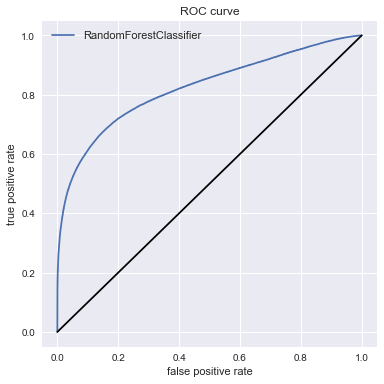

In [196]:
clfs ={'RandomForestClassifier': RandomForestClassifier(n_jobs=-1, max_features= 'auto', n_estimators=1000, random_state=42,
                                                        oob_score = True, min_samples_leaf=15, max_depth=20 )
            }
    

models_report, conf_matrix = run_models(clfs, loans_prepared, loans_labels)

In [197]:
models_report

,model,roc_auc_score,precision_score,recall_score,f1_score
0,RandomForestClassifier,0.823335,0.794626,0.705117,0.7472


In [198]:
conf_matrix['RandomForestClassifier']

Predicted,0.0,1.0
True,,
0.0,115677,25779
1.0,41713,99743


#### Feature Importance
Next we will take a closer look at the fitted model. What is the relative importance of each feature in its abiliity to sort out 
the "good loans" from the "bad loans". The RandomForestClassifier has an attribute called feature\_importances\_ which 
gives us the relative importance for each feature. This relative importance for each feature 
is obtained by randomly shuffling the values of that feature amongst the rows of the dataset and calculating the reduction in 
the ability to separate the "good loans" from the "bad loans" which is an indication of its predictive ability.


In [199]:
rfc_tuned=RandomForestClassifier(n_jobs=-1,max_features= 'auto', n_estimators=1000, random_state=42,
                                                        oob_score = True, min_samples_leaf=15, max_depth=20)
rfc_tuned.fit(loans_prepared, loans_labels)



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=15, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [200]:
importances = pd.DataFrame({'feature':loans_prepared.columns,'importance':np.round(rfc_tuned.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
 
print (importances)



                                  importance
feature                                     
dti_quant                              0.119
annual_inc_quant                       0.112
revol_util_quant                       0.095
loan_amnt_quant                        0.081
term_ 36 months                        0.066
term_ 60 months                        0.066
total_acc_quant                        0.057
revol_bal_quant                        0.045
length_credithist_quant                0.038
home_regrp_MORTGAGE                    0.036
home_regrp_RENT                        0.034
verified_edt_Verified                  0.028
verified_edt_Not Verified              0.028
inq_last_6mths_edit_None               0.027
purpose_regrp_debt                     0.021
inq_last_6mths_edit_1-2                0.020
delinq_2yrs_none_any_None              0.015
delinq_2yrs_none_any_Past Due          0.015
emp_length_regrp_0-10                  0.012
emp_length_regrp_10 +                  0.012
home_regrp

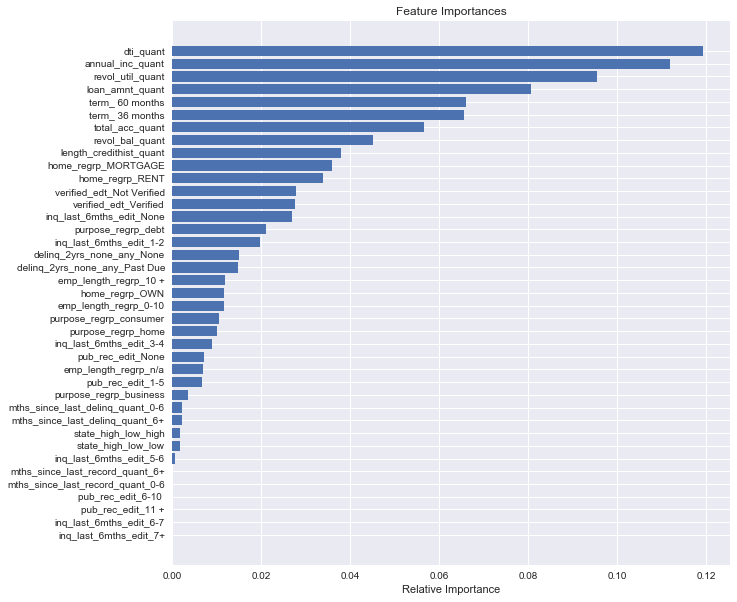

In [201]:
features = loans_prepared.columns
importances = rfc_tuned.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10, 10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

Looking at the feature importances, dti_quant is the most important but it accounts for only 12.8% of the relative importance.  The features dti\_quant,         annual\_inc\_quant, revol\_util\_quant, loan\_amnt\_quant, term, total\_acc\_quant ,revol\_bal\_quant, home\_regrp,            length\_credithist\_quant, verified\_edt and inq\_last\_6mths\_edit\_None  account for over 90% of importance. We will regroup inq\_last\_6mths into two groups inq\_last\_6mths\_edit\_lt\_2 (less than 2) and inq\_last\_6mths\_edit\_2+ (more than 2). The purpose_regrp will be put into two categories with debt and business together as purpose\_regrp\_debt\_busi and home and consumer together as purpose\_regrp\_other.
We will re-run the model keeping only these features.





In [202]:
loans_prepared["inq_last_6mths_edit_lt_2"] =loans_prepared["inq_last_6mths_edit_None"] +loans_prepared["inq_last_6mths_edit_1-2"] 
loans_prepared["inq_last_6mths_edit_2+"] =  loans_prepared["inq_last_6mths_edit_3-4"] +loans_prepared["inq_last_6mths_edit_5-6"] +loans_prepared["inq_last_6mths_edit_7+"]
loans_prepared["purpose_regrp_debt_busi"] =loans_prepared['purpose_regrp_debt'] +loans_prepared['purpose_regrp_business']   
loans_prepared["purpose_regrp_other"] =loans_prepared["purpose_regrp_home"] +loans_prepared["purpose_regrp_consumer"]
                                      
        

cols_to_drop = ["emp_length_regrp_10 +", "emp_length_regrp_n/a", "mths_since_last_delinq_quant_0-6" ,
                "delinq_2yrs_none_any_Past Due", "delinq_2yrs_none_any_None",  "pub_rec_edit_11 +", "pub_rec_edit_6-10 ",
                "pub_rec_edit_1-5", "pub_rec_edit_None" ,"mths_since_last_delinq_quant_6+", "mths_since_last_record_quant_6+" ,      
                "mths_since_last_record_quant_0-6", "state_high_low_high", "state_high_low_low", "inq_last_6mths_edit_None",
               "inq_last_6mths_edit_1-2",  "inq_last_6mths_edit_3-4", 
               "inq_last_6mths_edit_6-7","inq_last_6mths_edit_7+", 'purpose_regrp_debt','purpose_regrp_business',
                "purpose_regrp_home"  ,"purpose_regrp_consumer", 'emp_length_regrp_0-10','inq_last_6mths_edit_5-6']


loans_prepared.drop(cols_to_drop, axis=1, inplace=True)





In [203]:
loans_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282912 entries, 0 to 282911
Data columns (total 18 columns):
length_credithist_quant      282912 non-null float64
annual_inc_quant             282912 non-null float64
dti_quant                    282912 non-null float64
revol_bal_quant              282912 non-null float64
revol_util_quant             282912 non-null float64
total_acc_quant              282912 non-null float64
loan_amnt_quant              282912 non-null float64
term_ 36 months              282912 non-null float64
term_ 60 months              282912 non-null float64
home_regrp_MORTGAGE          282912 non-null float64
home_regrp_OWN               282912 non-null float64
home_regrp_RENT              282912 non-null float64
verified_edt_Not Verified    282912 non-null float64
verified_edt_Verified        282912 non-null float64
inq_last_6mths_edit_lt_2     282912 non-null float64
inq_last_6mths_edit_2+       282912 non-null float64
purpose_regrp_debt_busi      282912 non-n

In [223]:
rfc = RandomForestClassifier(n_jobs=-1, max_features= 'auto' ,n_estimators=10, oob_score = True, random_state=42 ) 

param_grid = { 
   'n_estimators': [250, 500, 1000],
   'max_features': ['auto'],
   'min_samples_leaf': [25, 30, 40 ],
   'max_depth': [5, 10]
}



CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(loans_prepared, loans_labels)

print (CV_rfc.best_params_)

{'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 25, 'n_estimators': 250}


In [224]:
rfc_tuned = RandomForestClassifier(n_jobs=-1, max_features= 'auto' , n_estimators=250, oob_score = True, random_state=42,
                             max_depth=10, min_samples_leaf=25 ) 

In [225]:
rfc_tuned.fit(loans_prepared, loans_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=25, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [226]:
loans_prob = rfc_tuned.predict_proba(loans_prepared)
loans_predictions = rfc_tuned.predict(loans_prepared)

cols = ['model', 'roc_auc_score', 'precision_score', 'recall_score','f1_score']

models_report = pd.DataFrame(columns = cols)
conf_matrix = dict()

tmp = pd.Series({ 'model': "Tuned Random Forest on Training Data",
                  'roc_auc_score' : metrics.roc_auc_score(loans_labels,  loans_prob[:,1]),
                  'precision_score': metrics.precision_score(loans_labels, loans_predictions ),
                  'recall_score': metrics.recall_score(loans_labels, loans_predictions),
                  'f1_score': metrics.f1_score(loans_labels, loans_predictions)})
models_report = models_report.append(tmp, ignore_index = True)

conf_matrix = pd.crosstab(loans_labels, loans_predictions, rownames=['True'], colnames= ['Predicted'], margins=False)

In [227]:
models_report

,model,roc_auc_score,precision_score,recall_score,f1_score
0,Tuned Random Forest on Training Data,0.819978,0.757245,0.700324,0.727673


In [228]:
conf_matrix

Predicted,0.0,1.0
True,,
0.0,109698,31758
1.0,42391,99065


In [229]:

feature_importances = rfc_tuned.feature_importances_
feature_importances

array([ 0.01945509,  0.13273183,  0.14763811,  0.02509105,  0.0962541 ,
        0.03811843,  0.10388652,  0.10703583,  0.09746626,  0.04873261,
        0.01144115,  0.04516148,  0.03649867,  0.03514563,  0.00801324,
        0.0091406 ,  0.01883234,  0.01935704])

In [230]:
importances = pd.DataFrame({'feature':loans_prepared.columns,'importance':np.round(rfc_tuned.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
 
print (importances)

                           importance
feature                              
dti_quant                       0.148
annual_inc_quant                0.133
term_ 36 months                 0.107
loan_amnt_quant                 0.104
term_ 60 months                 0.097
revol_util_quant                0.096
home_regrp_MORTGAGE             0.049
home_regrp_RENT                 0.045
total_acc_quant                 0.038
verified_edt_Not Verified       0.036
verified_edt_Verified           0.035
revol_bal_quant                 0.025
purpose_regrp_debt_busi         0.019
length_credithist_quant         0.019
purpose_regrp_other             0.019
home_regrp_OWN                  0.011
inq_last_6mths_edit_2+          0.009
inq_last_6mths_edit_lt_2        0.008


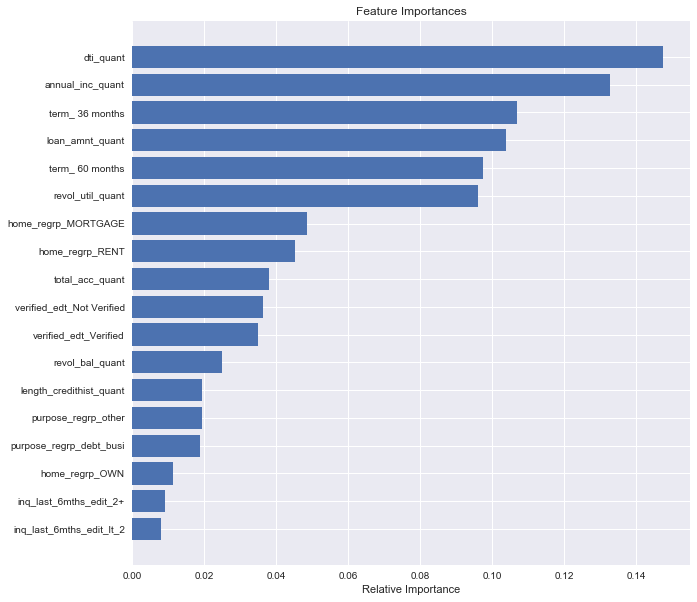

In [231]:
plt.figure(figsize=(10, 10))

features = loans_prepared.columns
importances = rfc_tuned.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

## Evaluate using Test Set.

We split the loan data earlier into a train and test set. Now we will use the model that we built using the train data to predict the status of the loans in the test data and compare the predictions to the true status of the loans. This will tell us how well the model generalizes.

In [215]:
X_test =pd.DataFrame(X_test, columns=X_test.columns)

In [216]:
X_test["inq_last_6mths_edit_lt_2"] =X_test["inq_last_6mths_edit_None"] +X_test["inq_last_6mths_edit_1-2"] 
X_test["inq_last_6mths_edit_2+"] =  X_test["inq_last_6mths_edit_3-4"] +X_test["inq_last_6mths_edit_5-6"] +X_test["inq_last_6mths_edit_7+"]
X_test["purpose_regrp_debt_busi"] =X_test['purpose_regrp_debt'] +X_test['purpose_regrp_business']   
X_test["purpose_regrp_other"] =X_test["purpose_regrp_home"] +X_test["purpose_regrp_consumer"]
                                      
        

cols_to_drop = ["emp_length_regrp_10 +", "emp_length_regrp_n/a", "mths_since_last_delinq_quant_0-6" ,
                "delinq_2yrs_none_any_Past Due", "delinq_2yrs_none_any_None",  "pub_rec_edit_11 +", "pub_rec_edit_6-10 ",
                "pub_rec_edit_1-5", "pub_rec_edit_None" ,"mths_since_last_delinq_quant_6+", "mths_since_last_record_quant_6+" ,      
                "mths_since_last_record_quant_0-6", "state_high_low_high", "state_high_low_low", "inq_last_6mths_edit_None",
               "inq_last_6mths_edit_1-2",  "inq_last_6mths_edit_3-4", 
               "inq_last_6mths_edit_6-7","inq_last_6mths_edit_7+", 'purpose_regrp_debt','purpose_regrp_business',
                "purpose_regrp_home"  ,"purpose_regrp_consumer", 'emp_length_regrp_0-10','inq_last_6mths_edit_5-6']


X_test.drop(cols_to_drop, axis=1, inplace=True)

In [232]:
final_prob = rfc_tuned.predict_proba(X_test)

In [233]:

final_predictions = rfc_tuned.predict(X_test)


In [234]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_test, final_predictions)

In [235]:
 
cols = ['model', 'roc_auc_score', 'precision_score', 'recall_score','f1_score']

models_report = pd.DataFrame(columns = cols)
conf_matrix = dict()

tmp = pd.Series({ 'model': "Random Forest on Test Data",
                  'roc_auc_score' : metrics.roc_auc_score(y_test, final_prob[:,1]),
                  'precision_score': metrics.precision_score(y_test, final_predictions),
                  'recall_score': metrics.recall_score(y_test, final_predictions),
                  'f1_score': metrics.f1_score(y_test, final_predictions)})
models_report = models_report.append(tmp, ignore_index = True)

conf_matrix = pd.crosstab(y_test, final_predictions, rownames=['True'], colnames= ['Predicted'], margins=False)

In [236]:
models_report




,model,roc_auc_score,precision_score,recall_score,f1_score
0,Random Forest on Test Data,0.660848,0.386283,0.437801,0.410432


In [222]:
conf_matrix

Predicted,0.0,1.0
True,,
0.0,50972,9652
1.0,12978,6757


On using the Random Forest model to predict the outcome for the loans on the test data the Roc_Auc Score dropped from 86% to 66%. The precision, recall and F1 scores are also low. This drop in scores from the training to the test indicate model overfitting. Model overfitting is where the model does not generalize well to unseen data indicating that the model is including residual variation particular to the training data as part of the model. This model cannot be used as is but steps need to be taken to address the overfitting.

Someways in  which we could address this:
1.  Instead of using SMOTE to address the imbalance ,give a higher weight to the error of miscclasssifying the bad loans. This would reduce the False Negatives. ie. Classifying a Bad loan as Good. 
2. It is possible that there are features that have a bigger impact on the default rate that is not present in the dataset. 
Include other features that may be relevant.
3. Further we optimized only the Random Forest. The performance of the logistic Rregression Model and the Gradient Boost models on the test set should be looked at as well. 

## Grading Loans based on probability of default.

Whilst the model obtained above is far from adequate and needs further refining before use, we can still use it to illustrate how to use the model to Grade the loans based on the risk of defaulting. 
 

When the model was fitted to the test data, each loan was assigned a probability of being either a "good loan" or a "bad loan". 
These probabilities are stored in the array final_prob where the 1st column is the probability of being a good loan (0) 
and the second column is hte probability of being a "bad loan" (1).

In [105]:
final_prob

array([[ 0.46354118,  0.53645882],
       [ 0.66305959,  0.33694041],
       [ 0.55848334,  0.44151666],
       ..., 
       [ 0.67541113,  0.32458887],
       [ 0.61937318,  0.38062682],
       [ 0.56453571,  0.43546429]])

We will create a data frame called final_data which will have the following columns:
    1. 'outcome' : The true status labels of the loans contained in Y_test
    2. 'final_prob' :The probabililty of being a "bad loan" (1) asssigned to each loan as obtained from fitting the model 
    3. 'final_pred_35', 'final_pred_40', "final_pred_45', 'final_pred_50' where each of these columns assign the loan to
        either 0 or 1 using the  probability of cutoff corresponding to 0.35, 0.40., 0.45 or 0.50 respectively.
         
 Then we will bin the 'final_prob' into 10 eqaul sized bins which will be labelled GRADE and using the groupby and aggregate to count the number of 1's in each GRADE for each of the above columns. 

In [106]:
final_data=pd.DataFrame(y_test)
final_data['final_prob']= pd.Series(final_prob[:,1], index=final_data.index)

prob_cuts={"35":0.35, "40": 0.40, "45": 0.45, "50" : 0.50}

for label, cut in prob_cuts.items():
    final_data['final_pred_'+ label] = np.where(final_data['final_prob'] >= cut,  1, 0)


final_data['BIN'] =pd.qcut(final_data['final_prob'], 10, labels=False)

count_bad_loans=final_data.groupby(['BIN'])['outcome', 'final_pred_35', 'final_pred_40', 'final_pred_45', 'final_pred_50'].agg( ['sum']).reset_index()
count_bad_loans

,BIN,outcome,final_pred_35,final_pred_40,final_pred_45,final_pred_50
,,sum,sum,sum,sum,sum
0,0,763.0,0,0,0,0
1,1,1128.0,0,0,0,0
2,2,1323.0,0,0,0,0
3,3,1512.0,5282,0,0,0
4,4,1736.0,8034,60,0,0
5,5,1947.0,8035,8035,0,0
6,6,2177.0,8036,8036,6429,0
7,7,2496.0,8038,8038,8038,6789
8,8,2868.0,8034,8034,8034,8034


The output above gives the 10 bins 0-9 labelled BIN and the count of 'bad loans' in each BIN. Under the column "outcome" is the true number of bad loans in that  BIN and in the other columns are the expected number of bad loans for that bin based on using the model probabilities and the given cutoff probability. 

We can use the true number of bad loans present in each bin to  calculate an adjustment for the interest rate that we would charge for any future loan whose probability would be predicted by the model to be in that bin. 

Suppose the expected profit per loan is 5% , then the total expected %profit for the bin is:
 Total number of loans in the bin *5. 
 We expect all loans in the bin to be good loans and thus if it was so the bin would yield this total. However as not all loans will be good the proportion of good loan will be less than the total in the bin. So we have to adjust the interst charged to reflect this decrease in good loans. ie. ( total count in bin)/ (total count in bin- number of bad loans in bin). 
 
 This is the adjustment factor by which the desired interest should be multiplied to account for the bad loans so that the desires profit would still be possible. The function adj_interest will calculate this for us when we groupby BIN and use this function with agg.


In [107]:
def adj_interest(series):
     
      return  len(series)/(len(series) -sum(series))
     
final_adj =final_data.groupby(['BIN'])['outcome'].agg([ adj_interest])
final_adj

,adj_interest
BIN,
0,1.104880
1,1.163289
2,1.197139
3,1.231689
4,1.275643
5,1.319809
6,1.371565
7,1.450379
8,1.555168
